In [9]:
from IPython.display import Image

# Постановка задачи

## Общий обзор: описать предметную область применительно
к решаемой задаче (теме диплома), оценить объём и доступность данных и информации по теме.

## Определение проблемы и составление стратегии решения
сформулировать исходную задачу, обосновать её важность,описать общий подход к решению, основные шаги.

Цель работы - создать работающую модель прогнозирования продаж для магазинов Спортмастер на примере продаж 1 модели велосипедов.


Почему это важно для велосипедов -
1. велосипеды являются крупногабаритным товаров, своевременный привоз которых в магазины важен во избежание затоваривания склада магазинов, оптимизации работы сборщиков и чтобы избежать нехватки товаров, либо, наоборот излишка (и проблем, связанных с его возвратом на центральный склад ит.д.)

2. В СМ есть сборочные предприятия, ресурс которых также ограничен и есть необходимость правильно распределить работу, чтобы завод не простаивал - т.к. это убытки для СМ.

## Целевые метрики: пояснить, как будете измерять качество
модели, почему выбрали такие метрики, перечислить
особенности и недостатки, на которые нужно обратить
внимание. Метрики должны отражать характеристики задачи
и предметной области. Обязательно нужны их формулы.

Основная проблем в том, что, для методов ML, которые планируется использовать в работе, нет единой метрики - классические методы анализа временных рядов используют критерий Акаике, в keras будем использовать rmse/mse, в классических методах ML будем использовать также rmse/mse. затем, для проведения финального сравнения эффективности работы приведем все ошибки к единому критерию - MAE 

*подумать, какой критерий в итоге нужно использовать

# Анализ

## Обзор аналогичных решений: кратко и со ссылками на
источники описать похожие решения и по возможности
результаты применения.

тут пока непонятно что использовать

## Предварительный анализ данных: исходные данные

Данных, которые удалось получить, не так много, чтобы проводить их подробный анализ - это объем продаж понедельно по 1 модели велосипеда.
Дополнительныйх данных, таких как тип магазина, населенный пункт, время продажи, праздники и т.д. - на этом этапе получить не удалось.

Основная задача сейчас - доказать, что это прогнозирование возможно, а затем детализировать прозноз

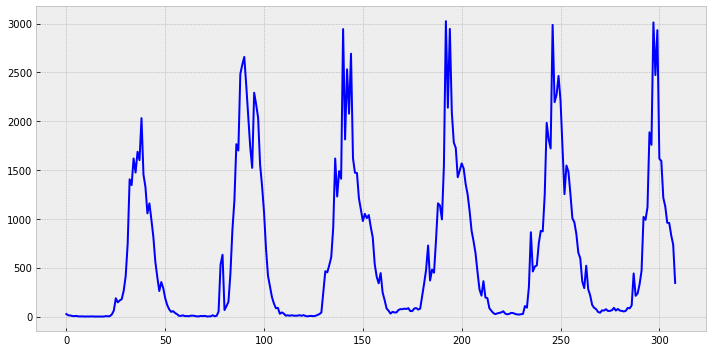

In [10]:
Image(filename='def_graph.png') 

## Алгоритмы и техники

В работе произведен расчет с помощью трех различных методик

### Классические методы анализа временных рядов

Т.к. рынок велосипедов в РФ - с ярко выраженной сезонностью, а методы классического анализа временных рядов отлично учитывают этот фактор. в работе планирую использовать сразу продвинутый метод прогнозирования SARIMA, минуя MA и т.д.

### Нейронные сети

Нейронные сети в н.в. стали наиболее быстро развивающимся сегментом ML, поэтому применение их в работе более чем обоснованно

### Классические методы ML

классические методы ML, такие как xbgoost и decision trees так же применяются при решении задач прогнозирования значений временных рядов. 

# Методика решения

## Классические алгоритмы анализа временных рядов

### Импорты

In [57]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta

from arch import arch_model

p = print

In [58]:
%matplotlib inline

In [59]:
df = pd.read_csv('raw_data_fin.csv', delimiter = ';')

### вывод таблицы

In [60]:
df.head()

,date,Sales
0,09.09.2012,25
1,16.09.2012,12
2,23.09.2012,11
3,30.09.2012,5
4,07.10.2012,4


In [61]:
df.columns = ['date','sales']

### функции графиков рядов

In [62]:
def tsplot(y, win, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    rolmean = y.rolling(window=win).mean()
    rolstd = pd.rolling_std(y, window=win)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        rolmean.plot(ax=ts_ax, color='red')
        rolstd.plot(ax=ts_ax, color='black')
        ts_ax.set_title('Original(blue), Rolling Mean(red) & Standard Deviation(black)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

In [63]:
def seasonal_decompose_plot(y,  freq=None):
    if not isinstance(y, pd.Series): # не является рядом?
        y = pd.Series(y) # преобразовать в ряд

    decomposition = seasonal_decompose(Y, freq=freq)
    # fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    return

In [64]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[0] > dftest[4]['5%']:
        print ('ряд не стационарен')
    else:
        print ('ряд стационарен')

### Предобработка данных: описать шаги по очистке и
преобразованию данных, способ их хранения и
представления для работы модели. Привести ссылку на
iPython-ноутбук или его раздел с соответствующим кодом.

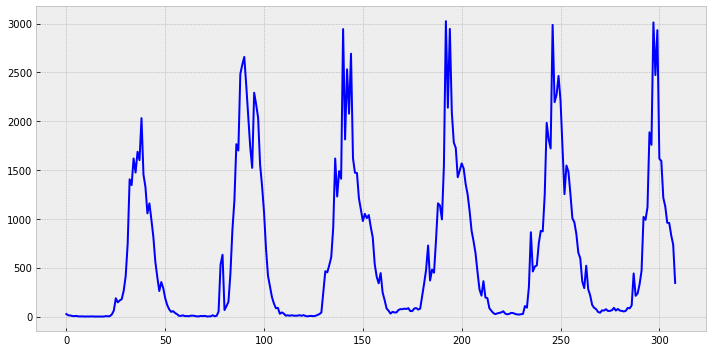

In [12]:
Image(filename='def_graph.png') 

### преобразуем даты в формат datetime

In [66]:
df.index.name=None
df.reset_index(inplace=True)

In [67]:
#  Укажем формат времени
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(df.sales))]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [68]:
df.head()

,date,sales
2012-09-09,09.09.2012,25
2012-09-16,16.09.2012,12
2012-09-23,23.09.2012,11
2012-09-30,30.09.2012,5
2012-10-07,07.10.2012,4


### рисуем графики ряда, AR, APR

сезон - 52 недели. но т.к. по факту, присутствуют два явных паттерна - полный ноль и продажи, используем так же и 26 недель

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=52,center=False).std()
  """


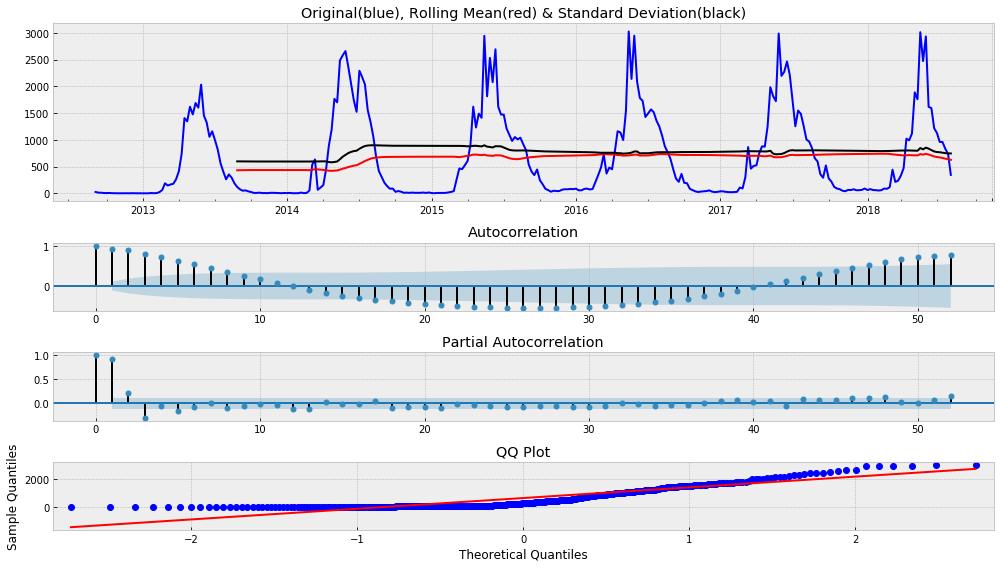

In [69]:
tsplot(df.sales, win=52, lags=52)

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).std()
  """


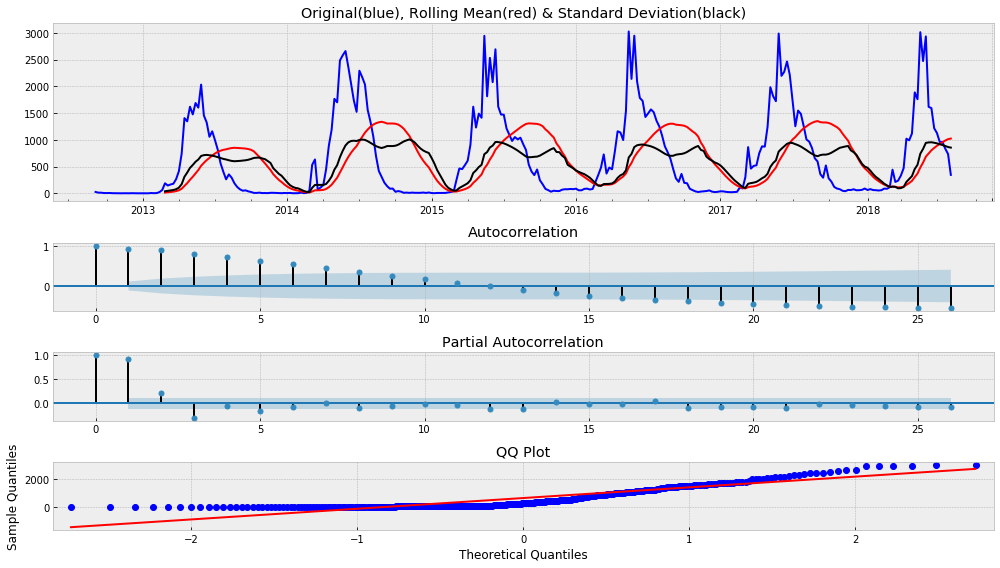

In [70]:
tsplot(df.sales, win=26, lags=26)

декомпозицию также построили по двум периодам, видим, что остатки при 52 все же менее системные

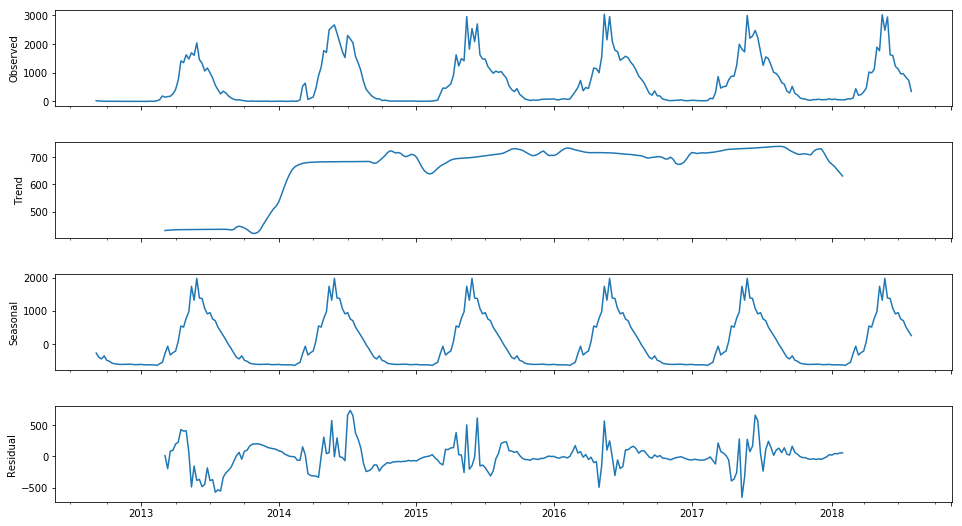

In [71]:
decomposition = seasonal_decompose(df.sales, freq=52)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

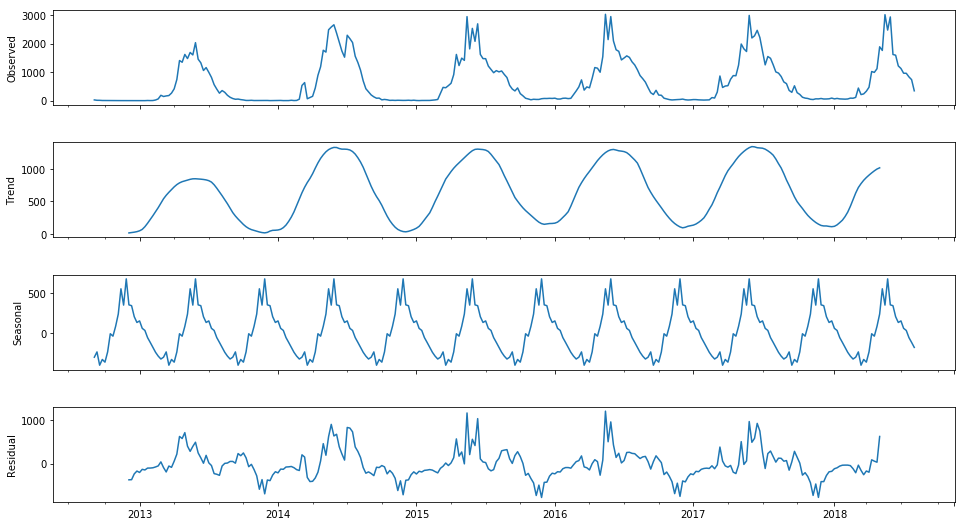

In [72]:
decomposition = seasonal_decompose(df.sales, freq=26)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

### проверка на стационарность

In [73]:
test_stationarity(df.sales)

Results of Dickey-Fuller Test:
Test Statistic                -5.770617e+00
p-value                        5.403200e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.960000e+02
Critical Value (1%)           -3.452637e+00
Critical Value (5%)           -2.871354e+00
Critical Value (10%)          -2.571999e+00
dtype: float64
ряд стационарен


### SARIMA

Подбор параметров SARIMAX осуществлялся вручную, без оптимизации гиперпараметров. Указанные параметры показали наиболее приемлемый результат среди около 20-30 наборов

In [74]:
mod = sm.tsa.statespace.SARIMAX(df.sales, order=(10,0,3), seasonal_order=(0,0,0,26), trend = 'n')
results = mod.fit()
p(results.summary())

C:\Pythonn\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                  309
Model:              SARIMAX(10, 0, 3)   Log Likelihood               -2169.700
Date:                Wed, 10 Oct 2018   AIC                           4367.400
Time:                        23:46:39   BIC                           4419.666
Sample:                    09-09-2012   HQIC                          4388.296
                         - 08-05-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6208      0.708      0.876      0.381      -0.767       2.009
ar.L2         -0.1408      0.149     -0.948      0.343      -0.432       0.150
ar.L3          0.8493      0.089      9.516      0.0

### Прогноз

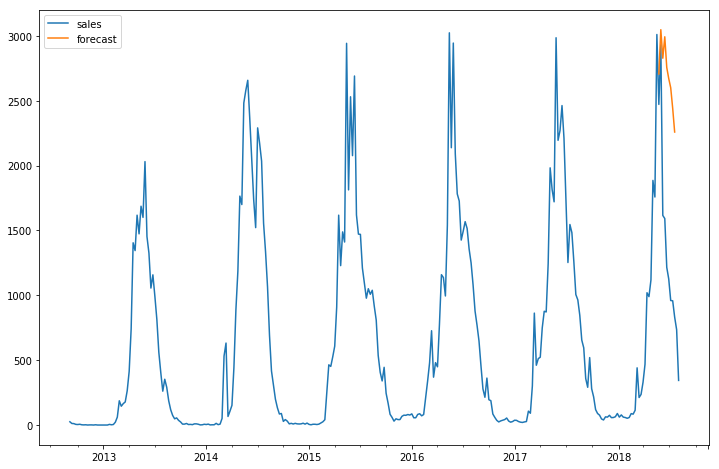

In [75]:
df['forecast'] = results.predict(start = 298, end= 306, dynamic= True)
df[['sales', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [76]:
rmse(Y_test, df.forecast[298:] )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Выводы

Как мы видим, даже учитывая ярко выраженную сезонность продаж, модель Sarima показала достаточно посредственный результат на интервале в 2 месяца (впрочем, на интервале 4-5 недель ошибка минимальна), сравним ее с другими методами ML

## Нейронная сеть. Классический метод

В нейронных сетях анализ проводился двумя разными способами, классический способ и способ с использованием кросс-валидации на сетях с 1-й эпохой

### Импорты

In [ ]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt

import keras

import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"

In [ ]:
import copy

In [ ]:
data = copy.deepcopy(df)

In [ ]:
data.index.name=None
data.reset_index(inplace=True)

In [ ]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(data.sales))]
data['index'] =date_list
data.set_index(['index'], inplace=True)
data.index.name=None

### написание функций для разбивки на train/test

Т.к. объем данных у нас небольшой, для искусственного увеличения последовательностей разобъем данные на отрезки по 26 недель (за основу возьмем финальный используемый в sarima интервал - полгода). использование 52 недель ухудшало точность в среднем на 10%

In [ ]:
def  shuffle_in_unison (a, b):

    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [ ]:
WINDOW = 26
STEP = 1
FORECAST = 11


X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        y = []

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

### Построение модели

Модель регрессии строилась в несколько итераций с последовательным усложнением - для последовательного улучшения и понимания какие методики работают, а какие - ухудшают качество

#### модель 1, сигмоид в функции активации

Используем линейную функцию активации на выходе и сигмоид в первом слое

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [ ]:
opt = Nadam(lr=0.0001)

In [ ]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [35]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/350
 - 0s - loss: 1040000.3298 - mean_squared_error: 1040000.3298 - val_loss: 1624576.4900 - val_mean_squared_error: 1624576.4900
Epoch 2/350
 - 0s - loss: 1039892.6522 - mean_squared_error: 1039892.6522 - val_loss: 1624403.2266 - val_mean_squared_error: 1624403.2266
Epoch 3/350
 - 0s - loss: 1039769.5699 - mean_squared_error: 1039769.5699 - val_loss: 1624213.5938 - val_mean_squared_error: 1624213.5938
Epoch 4/350
 - 0s - loss: 1039640.6812 - mean_squared_error: 1039640.6812 - val_loss: 1624034.4152 - val_mean_squared_error: 1624034.4152
Epoch 5/350
 - 0s - loss: 1039519.8645 - mean_squared_error: 1039519.8645 - val_loss: 1623861.4989 - val_mean_squared_error: 1623861.4989
Epoch 6/350
 - 0s - loss: 1039404.4299 - mean_squared_error: 1039404.4299 - val_loss: 1623686.5100 - val_mean_squared_error: 1623686.5100
Epoch 7/350
 - 0s - loss: 1039283.8479 - mean_squared_error: 1039283.8479 - val_loss: 1623512.5647 - val_mean_squared_error: 16

Epoch 60/350
 - 0s - loss: 1032771.8803 - mean_squared_error: 1032771.8803 - val_loss: 1613876.2634 - val_mean_squared_error: 1613876.2634
Epoch 61/350
 - 0s - loss: 1032648.8989 - mean_squared_error: 1032648.8989 - val_loss: 1613694.4721 - val_mean_squared_error: 1613694.4721
Epoch 62/350
 - 0s - loss: 1032524.6318 - mean_squared_error: 1032524.6318 - val_loss: 1613511.9330 - val_mean_squared_error: 1613511.9330
Epoch 63/350
 - 0s - loss: 1032400.4626 - mean_squared_error: 1032400.4626 - val_loss: 1613329.4587 - val_mean_squared_error: 1613329.4587
Epoch 64/350
 - 0s - loss: 1032276.3525 - mean_squared_error: 1032276.3525 - val_loss: 1613145.5636 - val_mean_squared_error: 1613145.5636
Epoch 65/350
 - 0s - loss: 1032149.9538 - mean_squared_error: 1032149.9538 - val_loss: 1612961.0123 - val_mean_squared_error: 1612961.0123
Epoch 66/350
 - 0s - loss: 1032022.5907 - mean_squared_error: 1032022.5907 - val_loss: 1612781.4364 - val_mean_squared_error: 1612781.4364
Epoch 67/350
 - 0s - loss: 

Epoch 119/350
 - 0s - loss: 1025779.1957 - mean_squared_error: 1025779.1957 - val_loss: 1603569.5547 - val_mean_squared_error: 1603569.5547
Epoch 120/350
 - 0s - loss: 1025663.9883 - mean_squared_error: 1025663.9883 - val_loss: 1603397.0915 - val_mean_squared_error: 1603397.0915
Epoch 121/350
 - 0s - loss: 1025547.4105 - mean_squared_error: 1025547.4105 - val_loss: 1603225.5045 - val_mean_squared_error: 1603225.5045
Epoch 122/350
 - 0s - loss: 1025432.0302 - mean_squared_error: 1025432.0302 - val_loss: 1603058.0379 - val_mean_squared_error: 1603058.0379
Epoch 123/350
 - 0s - loss: 1025319.6026 - mean_squared_error: 1025319.6026 - val_loss: 1602891.5201 - val_mean_squared_error: 1602891.5201
Epoch 124/350
 - 0s - loss: 1025205.9850 - mean_squared_error: 1025205.9850 - val_loss: 1602717.4565 - val_mean_squared_error: 1602717.4565
Epoch 125/350
 - 0s - loss: 1025088.3984 - mean_squared_error: 1025088.3984 - val_loss: 1602541.9821 - val_mean_squared_error: 1602541.9821
Epoch 126/350
 - 0s 

Epoch 178/350
 - 0s - loss: 1018858.5467 - mean_squared_error: 1018858.5467 - val_loss: 1593337.5938 - val_mean_squared_error: 1593337.5938
Epoch 179/350
 - 0s - loss: 1018739.4119 - mean_squared_error: 1018739.4119 - val_loss: 1593153.8225 - val_mean_squared_error: 1593153.8225
Epoch 180/350
 - 0s - loss: 1018612.2655 - mean_squared_error: 1018612.2655 - val_loss: 1592971.7176 - val_mean_squared_error: 1592971.7176
Epoch 181/350
 - 0s - loss: 1018489.2524 - mean_squared_error: 1018489.2524 - val_loss: 1592791.0525 - val_mean_squared_error: 1592791.0525
Epoch 182/350
 - 0s - loss: 1018368.2085 - mean_squared_error: 1018368.2085 - val_loss: 1592608.6150 - val_mean_squared_error: 1592608.6150
Epoch 183/350
 - 0s - loss: 1018246.4794 - mean_squared_error: 1018246.4794 - val_loss: 1592434.0859 - val_mean_squared_error: 1592434.0859
Epoch 184/350
 - 0s - loss: 1018127.2966 - mean_squared_error: 1018127.2966 - val_loss: 1592258.1585 - val_mean_squared_error: 1592258.1585
Epoch 185/350
 - 0s 

Epoch 237/350
 - 0s - loss: 1011324.4576 - mean_squared_error: 1011324.4576 - val_loss: 1582174.3337 - val_mean_squared_error: 1582174.3337
Epoch 238/350
 - 0s - loss: 1011191.2091 - mean_squared_error: 1011191.2091 - val_loss: 1581971.6094 - val_mean_squared_error: 1581971.6094
Epoch 239/350
 - 0s - loss: 1011054.7188 - mean_squared_error: 1011054.7188 - val_loss: 1581770.9408 - val_mean_squared_error: 1581770.9408
Epoch 240/350
 - 0s - loss: 1010919.9374 - mean_squared_error: 1010919.9374 - val_loss: 1581578.6384 - val_mean_squared_error: 1581578.6384
Epoch 241/350
 - 0s - loss: 1010790.5424 - mean_squared_error: 1010790.5424 - val_loss: 1581375.7031 - val_mean_squared_error: 1581375.7031
Epoch 242/350
 - 0s - loss: 1010655.8259 - mean_squared_error: 1010655.8259 - val_loss: 1581176.9386 - val_mean_squared_error: 1581176.9386
Epoch 243/350
 - 0s - loss: 1010521.5711 - mean_squared_error: 1010521.5711 - val_loss: 1580989.2946 - val_mean_squared_error: 1580989.2946
Epoch 244/350
 - 0s 

Epoch 296/350
 - 0s - loss: 1003262.9958 - mean_squared_error: 1003262.9958 - val_loss: 1570242.1161 - val_mean_squared_error: 1570242.1161
Epoch 297/350
 - 0s - loss: 1003114.9515 - mean_squared_error: 1003114.9515 - val_loss: 1570024.9464 - val_mean_squared_error: 1570024.9464
Epoch 298/350
 - 0s - loss: 1002964.8007 - mean_squared_error: 1002964.8007 - val_loss: 1569812.1049 - val_mean_squared_error: 1569812.1049
Epoch 299/350
 - 0s - loss: 1002819.6511 - mean_squared_error: 1002819.6511 - val_loss: 1569595.8449 - val_mean_squared_error: 1569595.8449
Epoch 300/350
 - 0s - loss: 1002676.0579 - mean_squared_error: 1002676.0579 - val_loss: 1569380.3248 - val_mean_squared_error: 1569380.3248
Epoch 301/350
 - 0s - loss: 1002528.2849 - mean_squared_error: 1002528.2849 - val_loss: 1569166.7444 - val_mean_squared_error: 1569166.7444
Epoch 302/350
 - 0s - loss: 1002381.1634 - mean_squared_error: 1002381.1634 - val_loss: 1568954.8114 - val_mean_squared_error: 1568954.8114
Epoch 303/350
 - 0s 

#### графики

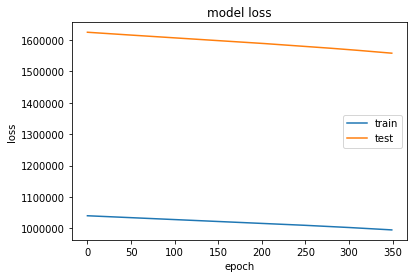

In [36]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

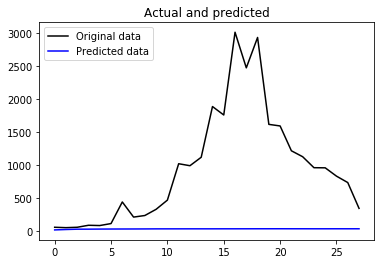

In [37]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель совсем не повторяет структуру данных

#### модель 2, добавили слой, два сигмоида, увеличили кол-во нейронов в первом слое, уменьшили кол-во эпох

In [38]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [39]:
opt = Nadam(lr=0.0001)

In [40]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [41]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/250
244/244 [==============================] - 0s 1ms/step - loss: 1039256.8043 - mean_squared_error: 1039256.8043 - val_loss: 1622573.3873 - val_mean_squared_error: 1622573.3873
Epoch 2/250
244/244 [==============================] - 0s 132us/step - loss: 1037966.5486 - mean_squared_error: 1037966.5486 - val_loss: 1620658.0324 - val_mean_squared_error: 1620658.0324
Epoch 3/250
244/244 [==============================] - 0s 126us/step - loss: 1036604.9848 - mean_squared_error: 1036604.9848 - val_loss: 1618677.5815 - val_mean_squared_error: 1618677.5815
Epoch 4/250
244/244 [==============================] - 0s 136us/step - loss: 1035236.2972 - mean_squared_error: 1035236.2972 - val_loss: 1616683.0904 - val_mean_squared_error: 1616683.0904
Epoch 5/250
244/244 [==============================] - 0s 150us/step - loss: 1033875.2586 - mean_squared_error: 1033875.2586 - val_loss: 1614756.0580 - val_mean_squared_error: 1614756.0580
Epoch 6/250


Epoch 44/250
244/244 [==============================] - 0s 193us/step - loss: 1004856.9529 - mean_squared_error: 1004856.9529 - val_loss: 1572995.7020 - val_mean_squared_error: 1572995.7020
Epoch 45/250
244/244 [==============================] - 0s 193us/step - loss: 1004347.2301 - mean_squared_error: 1004347.2301 - val_loss: 1572222.9252 - val_mean_squared_error: 1572222.9252
Epoch 46/250
244/244 [==============================] - 0s 195us/step - loss: 1003813.4636 - mean_squared_error: 1003813.4636 - val_loss: 1571472.4587 - val_mean_squared_error: 1571472.4587
Epoch 47/250
244/244 [==============================] - 0s 199us/step - loss: 1003305.9477 - mean_squared_error: 1003305.9477 - val_loss: 1570736.9208 - val_mean_squared_error: 1570736.9208
Epoch 48/250
244/244 [==============================] - 0s 191us/step - loss: 1002815.4176 - mean_squared_error: 1002815.4176 - val_loss: 1569985.1272 - val_mean_squared_error: 1569985.1272
Epoch 49/250
244/244 [============================

244/244 [==============================] - 0s 197us/step - loss: 962597.2419 - mean_squared_error: 962597.2419 - val_loss: 1510553.1808 - val_mean_squared_error: 1510553.1808
Epoch 131/250
244/244 [==============================] - 0s 171us/step - loss: 962116.8133 - mean_squared_error: 962116.8133 - val_loss: 1509853.2277 - val_mean_squared_error: 1509853.2277
Epoch 132/250
244/244 [==============================] - 0s 177us/step - loss: 961654.8244 - mean_squared_error: 961654.8244 - val_loss: 1509136.2723 - val_mean_squared_error: 1509136.2723
Epoch 133/250
244/244 [==============================] - 0s 203us/step - loss: 961168.2002 - mean_squared_error: 961168.2002 - val_loss: 1508436.3705 - val_mean_squared_error: 1508436.3705
Epoch 134/250
244/244 [==============================] - 0s 197us/step - loss: 960700.0944 - mean_squared_error: 960700.0944 - val_loss: 1507757.9275 - val_mean_squared_error: 1507757.9275
Epoch 135/250
244/244 [==============================] - 0s 183us/ste

244/244 [==============================] - 0s 193us/step - loss: 922003.0441 - mean_squared_error: 922003.0441 - val_loss: 1450093.2801 - val_mean_squared_error: 1450093.2801
Epoch 217/250
244/244 [==============================] - 0s 210us/step - loss: 921558.9649 - mean_squared_error: 921558.9649 - val_loss: 1449421.7087 - val_mean_squared_error: 1449421.7087
Epoch 218/250
244/244 [==============================] - 0s 205us/step - loss: 921112.3932 - mean_squared_error: 921112.3932 - val_loss: 1448772.1083 - val_mean_squared_error: 1448772.1083
Epoch 219/250
244/244 [==============================] - 0s 191us/step - loss: 920676.0087 - mean_squared_error: 920676.0087 - val_loss: 1448105.4408 - val_mean_squared_error: 1448105.4408
Epoch 220/250
244/244 [==============================] - 0s 205us/step - loss: 920232.6322 - mean_squared_error: 920232.6322 - val_loss: 1447457.9699 - val_mean_squared_error: 1447457.9699
Epoch 221/250
244/244 [==============================] - 0s 190us/ste

#### графики

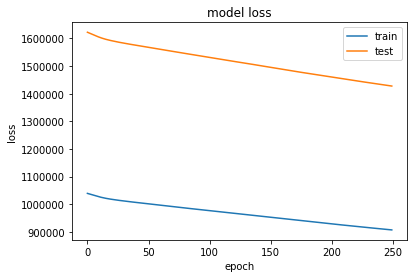

In [42]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

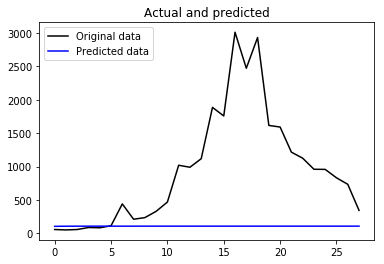

In [43]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель не работает

#### модель 3, попробовали tanh вместо sigmoid

In [44]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('tanh'))
model.add(Dense(360))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('linear'))

In [45]:
opt = Nadam(lr=0.0001)

In [46]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [47]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/250
244/244 [==============================] - 0s 2ms/step - loss: 1038445.3075 - mean_squared_error: 1038445.3075 - val_loss: 1620864.3404 - val_mean_squared_error: 1620864.3404
Epoch 2/250
244/244 [==============================] - 0s 163us/step - loss: 1037065.1162 - mean_squared_error: 1037065.1162 - val_loss: 1618843.3214 - val_mean_squared_error: 1618843.3214
Epoch 3/250
244/244 [==============================] - 0s 211us/step - loss: 1035481.8028 - mean_squared_error: 1035481.8028 - val_loss: 1616493.8873 - val_mean_squared_error: 1616493.8873
Epoch 4/250
244/244 [==============================] - 0s 195us/step - loss: 1033675.5212 - mean_squared_error: 1033675.5212 - val_loss: 1613808.4621 - val_mean_squared_error: 1613808.4621
Epoch 5/250
244/244 [==============================] - 0s 177us/step - loss: 1031652.1912 - mean_squared_error: 1031652.1912 - val_loss: 1610639.5033 - val_mean_squared_error: 1610639.5033
Epoch 6/250


Epoch 88/250
244/244 [==============================] - 0s 173us/step - loss: 942911.4480 - mean_squared_error: 942911.4480 - val_loss: 1475909.2210 - val_mean_squared_error: 1475909.2210
Epoch 89/250
244/244 [==============================] - 0s 162us/step - loss: 942258.2883 - mean_squared_error: 942258.2883 - val_loss: 1474897.2824 - val_mean_squared_error: 1474897.2824
Epoch 90/250
244/244 [==============================] - 0s 163us/step - loss: 941587.5660 - mean_squared_error: 941587.5660 - val_loss: 1473908.4386 - val_mean_squared_error: 1473908.4386
Epoch 91/250
244/244 [==============================] - 0s 158us/step - loss: 940938.4818 - mean_squared_error: 940938.4818 - val_loss: 1472896.0882 - val_mean_squared_error: 1472896.0882
Epoch 92/250
244/244 [==============================] - 0s 160us/step - loss: 940277.4065 - mean_squared_error: 940277.4065 - val_loss: 1471875.4900 - val_mean_squared_error: 1471875.4900
Epoch 93/250
244/244 [==============================] - 0s 1

244/244 [==============================] - 0s 191us/step - loss: 888143.3963 - mean_squared_error: 888143.3963 - val_loss: 1393087.4118 - val_mean_squared_error: 1393087.4118
Epoch 175/250
244/244 [==============================] - 0s 187us/step - loss: 887521.1757 - mean_squared_error: 887521.1757 - val_loss: 1392168.7701 - val_mean_squared_error: 1392168.7701
Epoch 176/250
244/244 [==============================] - 0s 196us/step - loss: 886877.2542 - mean_squared_error: 886877.2542 - val_loss: 1391264.5312 - val_mean_squared_error: 1391264.5312
Epoch 177/250
244/244 [==============================] - 0s 213us/step - loss: 886239.4165 - mean_squared_error: 886239.4165 - val_loss: 1390330.6663 - val_mean_squared_error: 1390330.6663
Epoch 178/250
244/244 [==============================] - 0s 191us/step - loss: 885580.0607 - mean_squared_error: 885580.0607 - val_loss: 1389441.1775 - val_mean_squared_error: 1389441.1775
Epoch 179/250
244/244 [==============================] - 0s 195us/ste

#### графики

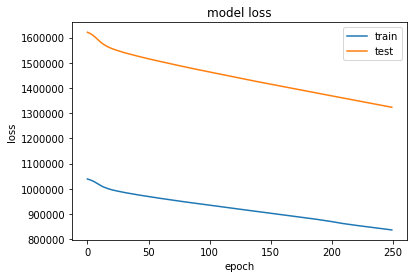

In [48]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

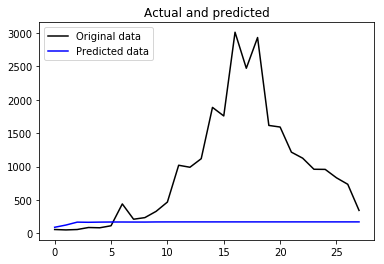

In [49]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель не работает

#### модель 4,  добавили reduce lr, вернули sigmoid

In [50]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [51]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

!!!!!! ОПИСАТЬ ЧТО ЭТО И ЗАЧЕМ!!!!!

In [52]:
opt = Nadam(lr=0.0001)

In [53]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [54]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/250
244/244 [==============================] - 0s 1ms/step - loss: 1038311.6384 - mean_squared_error: 1038311.6384 - val_loss: 1621218.5268 - val_mean_squared_error: 1621218.5268

Epoch 00001: val_loss improved from inf to 1621218.52679, saving model to test.hdf5
Epoch 2/250
244/244 [==============================] - 0s 183us/step - loss: 1037016.3819 - mean_squared_error: 1037016.3819 - val_loss: 1619197.2991 - val_mean_squared_error: 1619197.2991


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 00002: val_loss improved from 1621218.52679 to 1619197.29911, saving model to test.hdf5
Epoch 3/250
244/244 [==============================] - 0s 132us/step - loss: 1035609.3671 - mean_squared_error: 1035609.3671 - val_loss: 1617144.8538 - val_mean_squared_error: 1617144.8538

Epoch 00003: val_loss improved from 1619197.29911 to 1617144.85379, saving model to test.hdf5
Epoch 4/250
244/244 [==============================] - 0s 136us/step - loss: 1034199.6201 - mean_squared_error: 1034199.6201 - val_loss: 1615099.9051 - val_mean_squared_error: 1615099.9051

Epoch 00004: val_loss improved from 1617144.85379 to 1615099.90513, saving model to test.hdf5
Epoch 5/250
244/244 [==============================] - 0s 174us/step - loss: 1032807.5622 - mean_squared_error: 1032807.5622 - val_loss: 1613063.5804 - val_mean_squared_error: 1613063.5804

Epoch 00005: val_loss improved from 1615099.90513 to 1613063.58036, saving model to test.hdf5
Epoch 6/250
244/244 [==============================] 


Epoch 00031: val_loss improved from 1581382.59598 to 1580563.36049, saving model to test.hdf5
Epoch 32/250
244/244 [==============================] - 0s 146us/step - loss: 1009491.7722 - mean_squared_error: 1009491.7722 - val_loss: 1579740.0156 - val_mean_squared_error: 1579740.0156

Epoch 00032: val_loss improved from 1580563.36049 to 1579740.01562, saving model to test.hdf5
Epoch 33/250
244/244 [==============================] - 0s 197us/step - loss: 1008932.2044 - mean_squared_error: 1008932.2044 - val_loss: 1578907.7801 - val_mean_squared_error: 1578907.7801

Epoch 00033: val_loss improved from 1579740.01562 to 1578907.78013, saving model to test.hdf5
Epoch 34/250
244/244 [==============================] - 0s 201us/step - loss: 1008375.4429 - mean_squared_error: 1008375.4429 - val_loss: 1578096.1116 - val_mean_squared_error: 1578096.1116

Epoch 00034: val_loss improved from 1578907.78013 to 1578096.11161, saving model to test.hdf5
Epoch 35/250
244/244 [============================


Epoch 00060: val_loss improved from 1559197.97433 to 1558464.46540, saving model to test.hdf5
Epoch 61/250
244/244 [==============================] - 0s 181us/step - loss: 994471.1861 - mean_squared_error: 994471.1861 - val_loss: 1557705.6429 - val_mean_squared_error: 1557705.6429

Epoch 00061: val_loss improved from 1558464.46540 to 1557705.64286, saving model to test.hdf5
Epoch 62/250
244/244 [==============================] - 0s 195us/step - loss: 993945.1240 - mean_squared_error: 993945.1240 - val_loss: 1556960.3516 - val_mean_squared_error: 1556960.3516

Epoch 00062: val_loss improved from 1557705.64286 to 1556960.35156, saving model to test.hdf5
Epoch 63/250
244/244 [==============================] - 0s 199us/step - loss: 993439.1489 - mean_squared_error: 993439.1489 - val_loss: 1556196.0614 - val_mean_squared_error: 1556196.0614

Epoch 00063: val_loss improved from 1556960.35156 to 1556196.06138, saving model to test.hdf5
Epoch 64/250
244/244 [==============================] - 


Epoch 00089: val_loss improved from 1537396.55915 to 1536620.87723, saving model to test.hdf5
Epoch 90/250
244/244 [==============================] - 0s 191us/step - loss: 979661.7088 - mean_squared_error: 979661.7088 - val_loss: 1535901.8951 - val_mean_squared_error: 1535901.8951

Epoch 00090: val_loss improved from 1536620.87723 to 1535901.89509, saving model to test.hdf5
Epoch 91/250
244/244 [==============================] - 0s 195us/step - loss: 979172.0759 - mean_squared_error: 979172.0759 - val_loss: 1535140.5268 - val_mean_squared_error: 1535140.5268

Epoch 00091: val_loss improved from 1535901.89509 to 1535140.52679, saving model to test.hdf5
Epoch 92/250
244/244 [==============================] - 0s 203us/step - loss: 978658.0739 - mean_squared_error: 978658.0739 - val_loss: 1534365.9621 - val_mean_squared_error: 1534365.9621

Epoch 00092: val_loss improved from 1535140.52679 to 1534365.96205, saving model to test.hdf5
Epoch 93/250
244/244 [==============================] - 


Epoch 00118: val_loss improved from 1515920.06138 to 1515229.04353, saving model to test.hdf5
Epoch 119/250
244/244 [==============================] - 0s 191us/step - loss: 965272.9931 - mean_squared_error: 965272.9931 - val_loss: 1514533.9051 - val_mean_squared_error: 1514533.9051

Epoch 00119: val_loss improved from 1515229.04353 to 1514533.90513, saving model to test.hdf5
Epoch 120/250
244/244 [==============================] - 0s 195us/step - loss: 964801.4782 - mean_squared_error: 964801.4782 - val_loss: 1513837.2712 - val_mean_squared_error: 1513837.2712

Epoch 00120: val_loss improved from 1514533.90513 to 1513837.27121, saving model to test.hdf5
Epoch 121/250
244/244 [==============================] - 0s 196us/step - loss: 964329.9449 - mean_squared_error: 964329.9449 - val_loss: 1513140.3058 - val_mean_squared_error: 1513140.3058

Epoch 00121: val_loss improved from 1513837.27121 to 1513140.30580, saving model to test.hdf5
Epoch 122/250
244/244 [==============================


Epoch 00147: val_loss improved from 1495659.17969 to 1494951.99888, saving model to test.hdf5
Epoch 148/250
244/244 [==============================] - 0s 197us/step - loss: 951667.1624 - mean_squared_error: 951667.1624 - val_loss: 1494248.2924 - val_mean_squared_error: 1494248.2924

Epoch 00148: val_loss improved from 1494951.99888 to 1494248.29241, saving model to test.hdf5
Epoch 149/250
244/244 [==============================] - 0s 203us/step - loss: 951186.7321 - mean_squared_error: 951186.7321 - val_loss: 1493547.5792 - val_mean_squared_error: 1493547.5792

Epoch 00149: val_loss improved from 1494248.29241 to 1493547.57924, saving model to test.hdf5
Epoch 150/250
244/244 [==============================] - 0s 197us/step - loss: 950705.3339 - mean_squared_error: 950705.3339 - val_loss: 1492839.2567 - val_mean_squared_error: 1492839.2567

Epoch 00150: val_loss improved from 1493547.57924 to 1492839.25670, saving model to test.hdf5
Epoch 151/250
244/244 [==============================


Epoch 00176: val_loss improved from 1475178.56696 to 1474489.11272, saving model to test.hdf5
Epoch 177/250
244/244 [==============================] - 0s 201us/step - loss: 937946.8678 - mean_squared_error: 937946.8678 - val_loss: 1473821.3326 - val_mean_squared_error: 1473821.3326

Epoch 00177: val_loss improved from 1474489.11272 to 1473821.33259, saving model to test.hdf5
Epoch 178/250
244/244 [==============================] - 0s 199us/step - loss: 937500.4991 - mean_squared_error: 937500.4991 - val_loss: 1473117.3538 - val_mean_squared_error: 1473117.3538

Epoch 00178: val_loss improved from 1473821.33259 to 1473117.35379, saving model to test.hdf5
Epoch 179/250
244/244 [==============================] - 0s 201us/step - loss: 937020.7288 - mean_squared_error: 937020.7288 - val_loss: 1472431.4766 - val_mean_squared_error: 1472431.4766

Epoch 00179: val_loss improved from 1473117.35379 to 1472431.47656, saving model to test.hdf5
Epoch 180/250
244/244 [==============================


Epoch 00205: val_loss improved from 1455611.12612 to 1454920.86719, saving model to test.hdf5
Epoch 206/250
244/244 [==============================] - 0s 202us/step - loss: 924810.8322 - mean_squared_error: 924810.8322 - val_loss: 1454244.2533 - val_mean_squared_error: 1454244.2533

Epoch 00206: val_loss improved from 1454920.86719 to 1454244.25335, saving model to test.hdf5
Epoch 207/250
244/244 [==============================] - 0s 207us/step - loss: 924349.6347 - mean_squared_error: 924349.6347 - val_loss: 1453536.5123 - val_mean_squared_error: 1453536.5123

Epoch 00207: val_loss improved from 1454244.25335 to 1453536.51228, saving model to test.hdf5
Epoch 208/250
244/244 [==============================] - 0s 193us/step - loss: 923885.5753 - mean_squared_error: 923885.5753 - val_loss: 1452861.0134 - val_mean_squared_error: 1452861.0134

Epoch 00208: val_loss improved from 1453536.51228 to 1452861.01339, saving model to test.hdf5
Epoch 209/250
244/244 [==============================


Epoch 00234: val_loss improved from 1436212.42411 to 1435559.48326, saving model to test.hdf5
Epoch 235/250
244/244 [==============================] - 0s 157us/step - loss: 911811.0871 - mean_squared_error: 911811.0871 - val_loss: 1434896.0737 - val_mean_squared_error: 1434896.0737

Epoch 00235: val_loss improved from 1435559.48326 to 1434896.07366, saving model to test.hdf5
Epoch 236/250
244/244 [==============================] - 0s 144us/step - loss: 911364.3767 - mean_squared_error: 911364.3767 - val_loss: 1434249.3170 - val_mean_squared_error: 1434249.3170

Epoch 00236: val_loss improved from 1434896.07366 to 1434249.31696, saving model to test.hdf5
Epoch 237/250
244/244 [==============================] - 0s 149us/step - loss: 910916.3230 - mean_squared_error: 910916.3230 - val_loss: 1433572.5469 - val_mean_squared_error: 1433572.5469

Epoch 00237: val_loss improved from 1434249.31696 to 1433572.54688, saving model to test.hdf5
Epoch 238/250
244/244 [==============================

#### графики

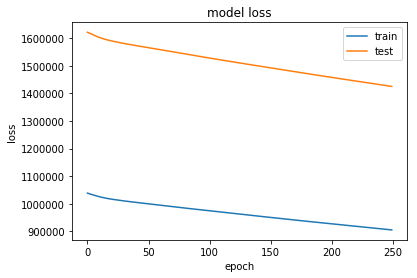

In [55]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

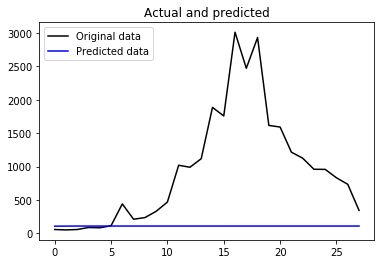

In [56]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель не работает

#### увеличили шаг, добавили регуляризацию, заменили сигмоид на релу

In [57]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

In [58]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [59]:
opt = Nadam(lr=0.001)

In [60]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [61]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/550
244/244 [==============================] - 0s 2ms/step - loss: 1033035.4521 - mean_squared_error: 1033033.9279 - val_loss: 1599730.5882 - val_mean_squared_error: 1599727.3237

Epoch 00001: val_loss improved from inf to 1599730.58817, saving model to test.hdf5
Epoch 2/550
 15/244 [>.............................] - ETA: 0s - loss: 1227958.6250 - mean_squared_error: 1227954.7500

C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


244/244 [==============================] - 0s 325us/step - loss: 999963.4009 - mean_squared_error: 999954.2103 - val_loss: 1521389.3036 - val_mean_squared_error: 1521365.8627

Epoch 00002: val_loss improved from 1599730.58817 to 1521389.30357, saving model to test.hdf5
Epoch 3/550
244/244 [==============================] - 0s 293us/step - loss: 904668.6584 - mean_squared_error: 904614.8401 - val_loss: 1317829.8650 - val_mean_squared_error: 1317702.4029

Epoch 00003: val_loss improved from 1521389.30357 to 1317829.86496, saving model to test.hdf5
Epoch 4/550
244/244 [==============================] - 0s 189us/step - loss: 711043.8385 - mean_squared_error: 710817.1327 - val_loss: 979473.1652 - val_mean_squared_error: 979018.3672

Epoch 00004: val_loss improved from 1317829.86496 to 979473.16518, saving model to test.hdf5
Epoch 5/550
244/244 [==============================] - 0s 212us/step - loss: 494742.8967 - mean_squared_error: 494129.6978 - val_loss: 696895.0513 - val_mean_squared_err


Epoch 00032: val_loss did not improve from 347986.43387
Epoch 33/550
244/244 [==============================] - 0s 179us/step - loss: 155895.5399 - mean_squared_error: 154114.1458 - val_loss: 360368.1643 - val_mean_squared_error: 357808.9992

Epoch 00033: val_loss did not improve from 347986.43387
Epoch 34/550
244/244 [==============================] - 0s 197us/step - loss: 153585.6164 - mean_squared_error: 151762.3393 - val_loss: 374893.6984 - val_mean_squared_error: 372243.7634

Epoch 00034: val_loss did not improve from 347986.43387
Epoch 35/550
244/244 [==============================] - 0s 208us/step - loss: 152326.4172 - mean_squared_error: 150439.7486 - val_loss: 352288.8304 - val_mean_squared_error: 349746.5151

Epoch 00035: val_loss did not improve from 347986.43387
Epoch 36/550
244/244 [==============================] - 0s 222us/step - loss: 152878.7403 - mean_squared_error: 151059.8796 - val_loss: 362026.0008 - val_mean_squared_error: 359359.3577

Epoch 00036: val_loss did n


Epoch 00099: val_loss did not improve from 345219.70006
Epoch 100/550
244/244 [==============================] - 0s 209us/step - loss: 97564.4507 - mean_squared_error: 94250.3410 - val_loss: 397220.1825 - val_mean_squared_error: 392873.0843

Epoch 00100: val_loss did not improve from 345219.70006
Epoch 101/550
244/244 [==============================] - 0s 215us/step - loss: 97705.3373 - mean_squared_error: 94330.1485 - val_loss: 389744.5438 - val_mean_squared_error: 385527.4506

Epoch 00101: val_loss did not improve from 345219.70006
Epoch 102/550
244/244 [==============================] - 0s 212us/step - loss: 95928.3207 - mean_squared_error: 92600.8355 - val_loss: 398675.1953 - val_mean_squared_error: 394556.8086

Epoch 00102: val_loss did not improve from 345219.70006
Epoch 103/550
244/244 [==============================] - 0s 222us/step - loss: 97802.8817 - mean_squared_error: 94494.9976 - val_loss: 406717.2402 - val_mean_squared_error: 402344.4835

Epoch 00103: val_loss did not i


Epoch 00133: val_loss did not improve from 345219.70006
Epoch 134/550
244/244 [==============================] - 0s 220us/step - loss: 80352.8231 - mean_squared_error: 76763.2841 - val_loss: 401622.8689 - val_mean_squared_error: 397080.1320

Epoch 00134: val_loss did not improve from 345219.70006
Epoch 135/550
244/244 [==============================] - 0s 209us/step - loss: 81161.2762 - mean_squared_error: 77506.9052 - val_loss: 387056.5025 - val_mean_squared_error: 382569.8563

Epoch 00135: val_loss did not improve from 345219.70006
Epoch 136/550
244/244 [==============================] - 0s 213us/step - loss: 79589.8827 - mean_squared_error: 75987.5630 - val_loss: 428036.3892 - val_mean_squared_error: 423446.4269

Epoch 00136: val_loss did not improve from 345219.70006
Epoch 137/550
244/244 [==============================] - 0s 222us/step - loss: 80376.8762 - mean_squared_error: 76669.6367 - val_loss: 421743.3111 - val_mean_squared_error: 417231.6886

Epoch 00137: val_loss did not i


Epoch 00167: val_loss did not improve from 345219.70006
Epoch 168/550
244/244 [==============================] - 0s 213us/step - loss: 69694.5275 - mean_squared_error: 65884.5307 - val_loss: 439453.8122 - val_mean_squared_error: 434765.8574

Epoch 00168: val_loss did not improve from 345219.70006
Epoch 169/550
244/244 [==============================] - 0s 154us/step - loss: 70515.2256 - mean_squared_error: 66694.8327 - val_loss: 427782.9743 - val_mean_squared_error: 423080.1590

Epoch 00169: val_loss did not improve from 345219.70006
Epoch 170/550
244/244 [==============================] - 0s 215us/step - loss: 69918.3649 - mean_squared_error: 66143.1820 - val_loss: 412404.7369 - val_mean_squared_error: 407711.1456

Epoch 00170: val_loss did not improve from 345219.70006
Epoch 171/550
244/244 [==============================] - 0s 211us/step - loss: 70296.0962 - mean_squared_error: 66485.0459 - val_loss: 423630.3158 - val_mean_squared_error: 418976.5642

Epoch 00171: val_loss did not i


Epoch 00201: val_loss did not improve from 345219.70006
Epoch 202/550
244/244 [==============================] - 0s 205us/step - loss: 64796.3871 - mean_squared_error: 61143.9639 - val_loss: 446799.5480 - val_mean_squared_error: 442181.2453

Epoch 00202: val_loss did not improve from 345219.70006
Epoch 203/550
244/244 [==============================] - 0s 211us/step - loss: 63050.7382 - mean_squared_error: 59338.4626 - val_loss: 399249.5656 - val_mean_squared_error: 394686.2520

Epoch 00203: val_loss did not improve from 345219.70006
Epoch 204/550
244/244 [==============================] - 0s 222us/step - loss: 64547.0402 - mean_squared_error: 60886.3821 - val_loss: 408144.1021 - val_mean_squared_error: 403596.6166

Epoch 00204: val_loss did not improve from 345219.70006
Epoch 205/550
244/244 [==============================] - 0s 209us/step - loss: 64526.8274 - mean_squared_error: 60857.5050 - val_loss: 429365.4860 - val_mean_squared_error: 424792.8186

Epoch 00205: val_loss did not i


Epoch 00235: val_loss did not improve from 345219.70006
Epoch 236/550
244/244 [==============================] - 0s 212us/step - loss: 58549.7523 - mean_squared_error: 55049.8551 - val_loss: 403148.7123 - val_mean_squared_error: 398621.2213

Epoch 00236: val_loss did not improve from 345219.70006
Epoch 237/550
244/244 [==============================] - 0s 155us/step - loss: 57562.0283 - mean_squared_error: 54097.5259 - val_loss: 431274.2246 - val_mean_squared_error: 426792.0566

Epoch 00237: val_loss did not improve from 345219.70006
Epoch 238/550
244/244 [==============================] - 0s 144us/step - loss: 56746.2794 - mean_squared_error: 53257.8195 - val_loss: 441746.6295 - val_mean_squared_error: 437288.3747

Epoch 00238: val_loss did not improve from 345219.70006
Epoch 239/550
244/244 [==============================] - 0s 159us/step - loss: 57532.9402 - mean_squared_error: 54051.9674 - val_loss: 424511.1800 - val_mean_squared_error: 420087.8864

Epoch 00239: val_loss did not i


Epoch 00269: val_loss did not improve from 345219.70006
Epoch 270/550
244/244 [==============================] - 0s 209us/step - loss: 52041.1816 - mean_squared_error: 48717.4739 - val_loss: 429257.9202 - val_mean_squared_error: 424953.1635

Epoch 00270: val_loss did not improve from 345219.70006
Epoch 271/550
244/244 [==============================] - 0s 206us/step - loss: 52380.1158 - mean_squared_error: 49156.1750 - val_loss: 462998.2586 - val_mean_squared_error: 458689.8287

Epoch 00271: val_loss did not improve from 345219.70006
Epoch 272/550
244/244 [==============================] - 0s 183us/step - loss: 51227.0696 - mean_squared_error: 47937.4996 - val_loss: 463241.7522 - val_mean_squared_error: 458966.1342

Epoch 00272: val_loss did not improve from 345219.70006
Epoch 273/550
244/244 [==============================] - 0s 150us/step - loss: 51730.6606 - mean_squared_error: 48486.8681 - val_loss: 459646.0033 - val_mean_squared_error: 455295.9774

Epoch 00273: val_loss did not i


Epoch 00303: val_loss did not improve from 345219.70006
Epoch 304/550
244/244 [==============================] - 0s 201us/step - loss: 46624.2261 - mean_squared_error: 43692.4869 - val_loss: 458620.7321 - val_mean_squared_error: 454621.5059

Epoch 00304: val_loss did not improve from 345219.70006
Epoch 305/550
244/244 [==============================] - 0s 150us/step - loss: 46309.3328 - mean_squared_error: 43374.1180 - val_loss: 454245.7054 - val_mean_squared_error: 450210.6777

Epoch 00305: val_loss did not improve from 345219.70006
Epoch 306/550
244/244 [==============================] - 0s 177us/step - loss: 46261.1449 - mean_squared_error: 43310.3967 - val_loss: 490450.1415 - val_mean_squared_error: 486462.9827

Epoch 00306: val_loss did not improve from 345219.70006
Epoch 307/550
244/244 [==============================] - 0s 215us/step - loss: 46540.5911 - mean_squared_error: 43635.2920 - val_loss: 497196.8566 - val_mean_squared_error: 493235.5879

Epoch 00307: val_loss did not i


Epoch 00337: val_loss did not improve from 345219.70006
Epoch 338/550
244/244 [==============================] - 0s 207us/step - loss: 41742.6160 - mean_squared_error: 39012.5666 - val_loss: 496042.1560 - val_mean_squared_error: 492185.9283

Epoch 00338: val_loss did not improve from 345219.70006
Epoch 339/550
244/244 [==============================] - 0s 207us/step - loss: 40745.9858 - mean_squared_error: 38036.9631 - val_loss: 518017.6981 - val_mean_squared_error: 514234.9791

Epoch 00339: val_loss did not improve from 345219.70006
Epoch 340/550
244/244 [==============================] - 0s 209us/step - loss: 41856.4381 - mean_squared_error: 39161.1406 - val_loss: 470481.8892 - val_mean_squared_error: 466675.9821

Epoch 00340: val_loss did not improve from 345219.70006
Epoch 341/550
244/244 [==============================] - 0s 213us/step - loss: 40711.1136 - mean_squared_error: 38005.4297 - val_loss: 504101.1334 - val_mean_squared_error: 500326.2746

Epoch 00341: val_loss did not i


Epoch 00371: val_loss did not improve from 345219.70006
Epoch 372/550
244/244 [==============================] - 0s 220us/step - loss: 38970.7250 - mean_squared_error: 36410.3699 - val_loss: 445399.3563 - val_mean_squared_error: 441680.4788

Epoch 00372: val_loss did not improve from 345219.70006
Epoch 373/550
244/244 [==============================] - 0s 207us/step - loss: 38184.1522 - mean_squared_error: 35536.4501 - val_loss: 488265.9609 - val_mean_squared_error: 484554.5299

Epoch 00373: val_loss did not improve from 345219.70006
Epoch 374/550
244/244 [==============================] - 0s 214us/step - loss: 36127.2711 - mean_squared_error: 33493.4314 - val_loss: 512947.2952 - val_mean_squared_error: 509268.2394

Epoch 00374: val_loss did not improve from 345219.70006
Epoch 375/550
244/244 [==============================] - 0s 218us/step - loss: 36504.1254 - mean_squared_error: 33905.2680 - val_loss: 493459.2266 - val_mean_squared_error: 489813.0645

Epoch 00375: val_loss did not i


Epoch 00405: val_loss did not improve from 345219.70006
Epoch 406/550
244/244 [==============================] - 0s 146us/step - loss: 32523.7034 - mean_squared_error: 30008.8023 - val_loss: 479219.8599 - val_mean_squared_error: 475680.6138

Epoch 00406: val_loss did not improve from 345219.70006
Epoch 407/550
244/244 [==============================] - 0s 146us/step - loss: 32134.9600 - mean_squared_error: 29635.8851 - val_loss: 473859.1889 - val_mean_squared_error: 470354.9408

Epoch 00407: val_loss did not improve from 345219.70006
Epoch 408/550
244/244 [==============================] - 0s 191us/step - loss: 33031.1694 - mean_squared_error: 30560.3428 - val_loss: 472078.4047 - val_mean_squared_error: 468497.9215

Epoch 00408: val_loss did not improve from 345219.70006
Epoch 409/550
244/244 [==============================] - 0s 197us/step - loss: 32376.6856 - mean_squared_error: 29864.2339 - val_loss: 504851.9699 - val_mean_squared_error: 501316.6085

Epoch 00409: val_loss did not i


Epoch 00439: val_loss did not improve from 345219.70006
Epoch 440/550
244/244 [==============================] - 0s 214us/step - loss: 29092.4863 - mean_squared_error: 26665.0290 - val_loss: 485854.6479 - val_mean_squared_error: 482456.1625

Epoch 00440: val_loss did not improve from 345219.70006
Epoch 441/550
244/244 [==============================] - 0s 213us/step - loss: 28788.4438 - mean_squared_error: 26351.0366 - val_loss: 481021.9644 - val_mean_squared_error: 477594.1568

Epoch 00441: val_loss did not improve from 345219.70006
Epoch 442/550
244/244 [==============================] - 0s 220us/step - loss: 28158.0867 - mean_squared_error: 25734.8794 - val_loss: 508841.1786 - val_mean_squared_error: 505460.9484

Epoch 00442: val_loss did not improve from 345219.70006
Epoch 443/550
244/244 [==============================] - 0s 211us/step - loss: 28036.5414 - mean_squared_error: 25620.0654 - val_loss: 480048.9799 - val_mean_squared_error: 476541.3050

Epoch 00443: val_loss did not i


Epoch 00473: val_loss did not improve from 345219.70006
Epoch 474/550
244/244 [==============================] - 0s 210us/step - loss: 25851.6474 - mean_squared_error: 23499.5323 - val_loss: 518109.7196 - val_mean_squared_error: 514837.3001

Epoch 00474: val_loss did not improve from 345219.70006
Epoch 475/550
244/244 [==============================] - 0s 217us/step - loss: 25362.0221 - mean_squared_error: 23015.8638 - val_loss: 512864.8096 - val_mean_squared_error: 509547.5306

Epoch 00475: val_loss did not improve from 345219.70006
Epoch 476/550
244/244 [==============================] - 0s 222us/step - loss: 25285.6482 - mean_squared_error: 22927.1085 - val_loss: 516341.0848 - val_mean_squared_error: 513009.9061

Epoch 00476: val_loss did not improve from 345219.70006
Epoch 477/550
244/244 [==============================] - 0s 214us/step - loss: 25272.7615 - mean_squared_error: 22952.7148 - val_loss: 583907.7974 - val_mean_squared_error: 580704.5064

Epoch 00477: val_loss did not i


Epoch 00507: val_loss did not improve from 345219.70006
Epoch 508/550
244/244 [==============================] - 0s 213us/step - loss: 22056.8624 - mean_squared_error: 19807.4683 - val_loss: 554705.8887 - val_mean_squared_error: 551611.1705

Epoch 00508: val_loss did not improve from 345219.70006
Epoch 509/550
244/244 [==============================] - 0s 207us/step - loss: 23991.3447 - mean_squared_error: 21740.3544 - val_loss: 483500.3227 - val_mean_squared_error: 480340.8722

Epoch 00509: val_loss did not improve from 345219.70006
Epoch 510/550
244/244 [==============================] - 0s 220us/step - loss: 22125.7109 - mean_squared_error: 19891.3368 - val_loss: 513329.2480 - val_mean_squared_error: 510178.4100

Epoch 00510: val_loss did not improve from 345219.70006
Epoch 511/550
244/244 [==============================] - 0s 211us/step - loss: 22526.1122 - mean_squared_error: 20267.4665 - val_loss: 476412.5879 - val_mean_squared_error: 473245.8277

Epoch 00511: val_loss did not i


Epoch 00541: val_loss did not improve from 345219.70006
Epoch 542/550
244/244 [==============================] - 0s 205us/step - loss: 19419.5664 - mean_squared_error: 17180.9395 - val_loss: 536554.3965 - val_mean_squared_error: 533497.1635

Epoch 00542: val_loss did not improve from 345219.70006
Epoch 543/550
244/244 [==============================] - 0s 160us/step - loss: 19503.1753 - mean_squared_error: 17289.2441 - val_loss: 509526.4283 - val_mean_squared_error: 506429.1667

Epoch 00543: val_loss did not improve from 345219.70006
Epoch 544/550
244/244 [==============================] - 0s 209us/step - loss: 19009.3311 - mean_squared_error: 16795.6526 - val_loss: 553520.6783 - val_mean_squared_error: 550443.5838

Epoch 00544: val_loss did not improve from 345219.70006
Epoch 545/550
244/244 [==============================] - 0s 186us/step - loss: 19255.5281 - mean_squared_error: 17034.4941 - val_loss: 540836.8696 - val_mean_squared_error: 537795.2739

Epoch 00545: val_loss did not i

#### графики

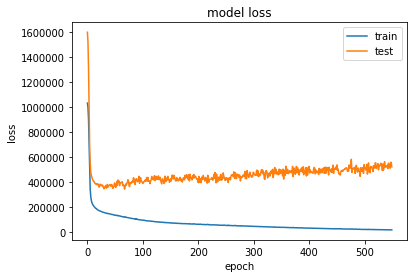

In [62]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

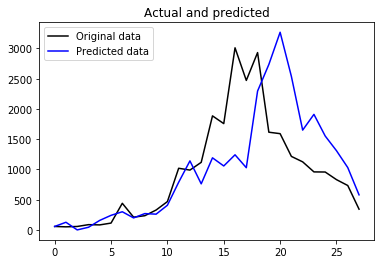

In [63]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель начала повторять структуру графика, мы на верном пути

#### модель 6 добавили batch normalization

In [64]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

!!!! ОПИСАТЬ ЧТО ТАКОЕ BATCH NORMALIZATION !!!!!

In [65]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [66]:
opt = Nadam(lr=0.001)

In [67]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [68]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/550
244/244 [==============================] - 1s 5ms/step - loss: 1031991.6670 - mean_squared_error: 1031989.2390 - val_loss: 1605434.4397 - val_mean_squared_error: 1605432.3069

Epoch 00001: val_loss improved from inf to 1605434.43973, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/550
244/244 [==============================] - 0s 201us/step - loss: 1021145.5288 - mean_squared_error: 1021142.5539 - val_loss: 1591710.6741 - val_mean_squared_error: 1591708.1261

Epoch 00002: val_loss improved from 1605434.43973 to 1591710.67411, saving model to test.hdf5
Epoch 3/550
244/244 [==============================] - 0s 199us/step - loss: 1013336.0704 - mean_squared_error: 1013332.7114 - val_loss: 1578488.2913 - val_mean_squared_error: 1578485.2935

Epoch 00003: val_loss improved from 1591710.67411 to 1578488.29129, saving model to test.hdf5
Epoch 4/550
244/244 [==============================] - 0s 222us/step - loss: 1004014.2925 - mean_squared_error: 1004010.5602 - val_loss: 1560891.3348 - val_mean_squared_error: 1560888.3717

Epoch 00004: val_loss improved from 1578488.29129 to 1560891.33482, saving model to test.hdf5
Epoch 5/550
244/244 [==============================] - 0s 258us/step - loss: 995384.2691 - mean_squared_error: 995380.2738 - val_loss: 1552570.7556 

Epoch 32/550
244/244 [==============================] - 0s 181us/step - loss: 480189.0911 - mean_squared_error: 480179.0795 - val_loss: 686305.7690 - val_mean_squared_error: 686290.7600

Epoch 00032: val_loss did not improve from 611347.89118
Epoch 33/550
244/244 [==============================] - 0s 173us/step - loss: 458517.9012 - mean_squared_error: 458508.4674 - val_loss: 761072.2533 - val_mean_squared_error: 761058.6663

Epoch 00033: val_loss did not improve from 611347.89118
Epoch 34/550
244/244 [==============================] - 0s 179us/step - loss: 430370.5943 - mean_squared_error: 430362.1111 - val_loss: 661264.8225 - val_mean_squared_error: 661251.0329

Epoch 00034: val_loss did not improve from 611347.89118
Epoch 35/550
244/244 [==============================] - 0s 173us/step - loss: 412929.8478 - mean_squared_error: 412921.1438 - val_loss: 734371.8404 - val_mean_squared_error: 734359.4788

Epoch 00035: val_loss did not improve from 611347.89118
Epoch 36/550
244/244 [======

244/244 [==============================] - 0s 215us/step - loss: 132505.7428 - mean_squared_error: 132498.2109 - val_loss: 591896.6557 - val_mean_squared_error: 591887.2891

Epoch 00065: val_loss did not improve from 364282.75530
Epoch 66/550
244/244 [==============================] - 0s 213us/step - loss: 135460.8255 - mean_squared_error: 135453.8167 - val_loss: 442392.8465 - val_mean_squared_error: 442383.8449

Epoch 00066: val_loss did not improve from 364282.75530
Epoch 67/550
244/244 [==============================] - 0s 197us/step - loss: 121508.3705 - mean_squared_error: 121501.1242 - val_loss: 500530.7930 - val_mean_squared_error: 500521.7662

Epoch 00067: val_loss did not improve from 364282.75530
Epoch 68/550
244/244 [==============================] - 0s 185us/step - loss: 170097.1577 - mean_squared_error: 170090.2442 - val_loss: 726286.0949 - val_mean_squared_error: 726275.4141

Epoch 00068: val_loss did not improve from 364282.75530
Epoch 69/550
244/244 [===================

244/244 [==============================] - 0s 262us/step - loss: 106787.1068 - mean_squared_error: 106779.7819 - val_loss: 553200.2676 - val_mean_squared_error: 553191.2584

Epoch 00099: val_loss did not improve from 364282.75530
Epoch 100/550
244/244 [==============================] - 0s 266us/step - loss: 109135.3536 - mean_squared_error: 109127.6090 - val_loss: 600832.6440 - val_mean_squared_error: 600822.9905

Epoch 00100: val_loss did not improve from 364282.75530
Epoch 101/550
244/244 [==============================] - 0s 271us/step - loss: 94263.2000 - mean_squared_error: 94255.7474 - val_loss: 668238.6222 - val_mean_squared_error: 668229.2165

Epoch 00101: val_loss did not improve from 364282.75530
Epoch 102/550
244/244 [==============================] - 0s 297us/step - loss: 107684.2665 - mean_squared_error: 107676.7647 - val_loss: 570106.6194 - val_mean_squared_error: 570097.8117

Epoch 00102: val_loss did not improve from 364282.75530
Epoch 103/550
244/244 [=================


Epoch 00132: val_loss did not improve from 364282.75530
Epoch 133/550
244/244 [==============================] - 0s 262us/step - loss: 90216.6317 - mean_squared_error: 90209.6855 - val_loss: 581933.3552 - val_mean_squared_error: 581925.1191

Epoch 00133: val_loss did not improve from 364282.75530
Epoch 134/550
244/244 [==============================] - 0s 268us/step - loss: 91075.6809 - mean_squared_error: 91068.8940 - val_loss: 442028.9169 - val_mean_squared_error: 442021.1144

Epoch 00134: val_loss did not improve from 364282.75530
Epoch 135/550
244/244 [==============================] - 0s 259us/step - loss: 109038.0597 - mean_squared_error: 109031.0601 - val_loss: 600361.5525 - val_mean_squared_error: 600353.1652

Epoch 00135: val_loss did not improve from 364282.75530
Epoch 136/550
244/244 [==============================] - 0s 193us/step - loss: 98658.0895 - mean_squared_error: 98651.0505 - val_loss: 580340.8943 - val_mean_squared_error: 580332.1300

Epoch 00136: val_loss did not

244/244 [==============================] - 0s 159us/step - loss: 106042.3171 - mean_squared_error: 106035.4244 - val_loss: 579429.0728 - val_mean_squared_error: 579420.4738

Epoch 00200: val_loss did not improve from 364282.75530
Epoch 201/550
244/244 [==============================] - 0s 171us/step - loss: 100879.6335 - mean_squared_error: 100872.5434 - val_loss: 576318.6423 - val_mean_squared_error: 576310.1989

Epoch 00201: val_loss did not improve from 364282.75530
Epoch 202/550
244/244 [==============================] - 0s 175us/step - loss: 65453.5429 - mean_squared_error: 65446.8426 - val_loss: 566707.6978 - val_mean_squared_error: 566699.4057

Epoch 00202: val_loss did not improve from 364282.75530
Epoch 203/550
244/244 [==============================] - 0s 176us/step - loss: 82924.0807 - mean_squared_error: 82917.1610 - val_loss: 573505.4947 - val_mean_squared_error: 573497.0128

Epoch 00203: val_loss did not improve from 364282.75530
Epoch 204/550
244/244 [===================

244/244 [==============================] - 0s 177us/step - loss: 108134.7848 - mean_squared_error: 108127.8381 - val_loss: 667335.0851 - val_mean_squared_error: 667326.0070

Epoch 00234: val_loss did not improve from 364282.75530
Epoch 235/550
244/244 [==============================] - 0s 177us/step - loss: 83188.6854 - mean_squared_error: 83181.9881 - val_loss: 610908.9688 - val_mean_squared_error: 610900.0873

Epoch 00235: val_loss did not improve from 364282.75530
Epoch 236/550
244/244 [==============================] - 0s 179us/step - loss: 87574.1589 - mean_squared_error: 87567.4299 - val_loss: 598398.9099 - val_mean_squared_error: 598389.8407

Epoch 00236: val_loss did not improve from 364282.75530
Epoch 237/550
244/244 [==============================] - 0s 173us/step - loss: 74842.6435 - mean_squared_error: 74835.6944 - val_loss: 663313.0374 - val_mean_squared_error: 663303.6247

Epoch 00237: val_loss did not improve from 364282.75530
Epoch 238/550
244/244 [=====================

244/244 [==============================] - 0s 264us/step - loss: 60556.8718 - mean_squared_error: 60549.9964 - val_loss: 536670.6991 - val_mean_squared_error: 536662.0237

Epoch 00268: val_loss did not improve from 364282.75530
Epoch 269/550
244/244 [==============================] - 0s 262us/step - loss: 91722.5897 - mean_squared_error: 91715.8518 - val_loss: 556282.1875 - val_mean_squared_error: 556273.4639

Epoch 00269: val_loss did not improve from 364282.75530
Epoch 270/550
244/244 [==============================] - 0s 274us/step - loss: 76209.5179 - mean_squared_error: 76202.6990 - val_loss: 601387.5198 - val_mean_squared_error: 601378.8231

Epoch 00270: val_loss did not improve from 364282.75530
Epoch 271/550
244/244 [==============================] - 0s 258us/step - loss: 62314.9536 - mean_squared_error: 62308.1399 - val_loss: 603410.7626 - val_mean_squared_error: 603402.0402

Epoch 00271: val_loss did not improve from 364282.75530
Epoch 272/550
244/244 [=======================

244/244 [==============================] - 0s 270us/step - loss: 70409.8740 - mean_squared_error: 70403.5391 - val_loss: 641405.9604 - val_mean_squared_error: 641398.0153

Epoch 00302: val_loss did not improve from 364282.75530
Epoch 303/550
244/244 [==============================] - 0s 238us/step - loss: 71023.7271 - mean_squared_error: 71017.2535 - val_loss: 643865.4397 - val_mean_squared_error: 643857.3764

Epoch 00303: val_loss did not improve from 364282.75530
Epoch 304/550
244/244 [==============================] - 0s 248us/step - loss: 74580.9775 - mean_squared_error: 74574.2820 - val_loss: 575097.4994 - val_mean_squared_error: 575089.3343

Epoch 00304: val_loss did not improve from 364282.75530
Epoch 305/550
244/244 [==============================] - 0s 222us/step - loss: 74359.8601 - mean_squared_error: 74353.1531 - val_loss: 642350.9830 - val_mean_squared_error: 642342.7341

Epoch 00305: val_loss did not improve from 364282.75530
Epoch 306/550
244/244 [=======================

244/244 [==============================] - 0s 177us/step - loss: 93864.3948 - mean_squared_error: 93857.9560 - val_loss: 811906.8315 - val_mean_squared_error: 811898.3583

Epoch 00336: val_loss did not improve from 364282.75530
Epoch 337/550
244/244 [==============================] - 0s 236us/step - loss: 74929.0875 - mean_squared_error: 74922.4448 - val_loss: 607158.3239 - val_mean_squared_error: 607150.2462

Epoch 00337: val_loss did not improve from 364282.75530
Epoch 338/550
244/244 [==============================] - 0s 246us/step - loss: 85537.9004 - mean_squared_error: 85531.4242 - val_loss: 707136.6535 - val_mean_squared_error: 707128.3172

Epoch 00338: val_loss did not improve from 364282.75530
Epoch 339/550
244/244 [==============================] - 0s 234us/step - loss: 79950.6593 - mean_squared_error: 79944.0280 - val_loss: 534501.5191 - val_mean_squared_error: 534493.2860

Epoch 00339: val_loss did not improve from 364282.75530
Epoch 340/550
244/244 [=======================

244/244 [==============================] - 0s 228us/step - loss: 81076.9286 - mean_squared_error: 81070.3643 - val_loss: 627850.0766 - val_mean_squared_error: 627841.6201

Epoch 00370: val_loss did not improve from 364282.75530
Epoch 371/550
244/244 [==============================] - 0s 209us/step - loss: 88114.9184 - mean_squared_error: 88108.5176 - val_loss: 579792.7391 - val_mean_squared_error: 579784.6607

Epoch 00371: val_loss did not improve from 364282.75530
Epoch 372/550
244/244 [==============================] - 0s 171us/step - loss: 56023.9728 - mean_squared_error: 56017.1054 - val_loss: 624044.2310 - val_mean_squared_error: 624035.7614

Epoch 00372: val_loss did not improve from 364282.75530
Epoch 373/550
244/244 [==============================] - 0s 193us/step - loss: 62864.2166 - mean_squared_error: 62857.4009 - val_loss: 613086.7285 - val_mean_squared_error: 613078.5020

Epoch 00373: val_loss did not improve from 364282.75530
Epoch 374/550
244/244 [=======================

244/244 [==============================] - 0s 260us/step - loss: 73832.0606 - mean_squared_error: 73825.8796 - val_loss: 674213.4855 - val_mean_squared_error: 674205.6607

Epoch 00404: val_loss did not improve from 364282.75530
Epoch 405/550
244/244 [==============================] - 0s 266us/step - loss: 77112.9763 - mean_squared_error: 77107.1005 - val_loss: 599873.1913 - val_mean_squared_error: 599865.5474

Epoch 00405: val_loss did not improve from 364282.75530
Epoch 406/550
244/244 [==============================] - 0s 256us/step - loss: 60136.4708 - mean_squared_error: 60130.4964 - val_loss: 707998.9251 - val_mean_squared_error: 707990.9561

Epoch 00406: val_loss did not improve from 364282.75530
Epoch 407/550
244/244 [==============================] - 0s 264us/step - loss: 78751.9628 - mean_squared_error: 78745.8219 - val_loss: 623801.4245 - val_mean_squared_error: 623793.3790

Epoch 00407: val_loss did not improve from 364282.75530
Epoch 408/550
244/244 [=======================

244/244 [==============================] - 0s 260us/step - loss: 71329.2159 - mean_squared_error: 71323.1103 - val_loss: 667266.2275 - val_mean_squared_error: 667258.1250

Epoch 00438: val_loss did not improve from 364282.75530
Epoch 439/550
244/244 [==============================] - 0s 270us/step - loss: 70569.1483 - mean_squared_error: 70562.6063 - val_loss: 621824.1271 - val_mean_squared_error: 621815.9901

Epoch 00439: val_loss did not improve from 364282.75530
Epoch 440/550
244/244 [==============================] - 0s 260us/step - loss: 66235.6233 - mean_squared_error: 66229.0172 - val_loss: 695437.7906 - val_mean_squared_error: 695429.6854

Epoch 00440: val_loss did not improve from 364282.75530
Epoch 441/550
244/244 [==============================] - 0s 264us/step - loss: 76003.4575 - mean_squared_error: 75996.8315 - val_loss: 647897.9261 - val_mean_squared_error: 647890.1310

Epoch 00441: val_loss did not improve from 364282.75530
Epoch 442/550
244/244 [=======================

244/244 [==============================] - 0s 218us/step - loss: 64055.8593 - mean_squared_error: 64049.4880 - val_loss: 672143.5257 - val_mean_squared_error: 672135.7877

Epoch 00472: val_loss did not improve from 364282.75530
Epoch 473/550
244/244 [==============================] - 0s 234us/step - loss: 72889.4054 - mean_squared_error: 72883.2628 - val_loss: 637567.8086 - val_mean_squared_error: 637559.6978

Epoch 00473: val_loss did not improve from 364282.75530
Epoch 474/550
244/244 [==============================] - 0s 213us/step - loss: 70071.5911 - mean_squared_error: 70064.9626 - val_loss: 644675.4182 - val_mean_squared_error: 644666.6249

Epoch 00474: val_loss did not improve from 364282.75530
Epoch 475/550
244/244 [==============================] - 0s 246us/step - loss: 68463.9234 - mean_squared_error: 68457.4892 - val_loss: 613782.0114 - val_mean_squared_error: 613773.5459

Epoch 00475: val_loss did not improve from 364282.75530
Epoch 476/550
244/244 [=======================

244/244 [==============================] - 0s 171us/step - loss: 75863.1958 - mean_squared_error: 75856.8001 - val_loss: 606551.7455 - val_mean_squared_error: 606543.3126

Epoch 00506: val_loss did not improve from 364282.75530
Epoch 507/550
244/244 [==============================] - 0s 171us/step - loss: 72706.7980 - mean_squared_error: 72700.2717 - val_loss: 624111.4047 - val_mean_squared_error: 624102.9530

Epoch 00507: val_loss did not improve from 364282.75530
Epoch 508/550
244/244 [==============================] - 0s 211us/step - loss: 46669.7780 - mean_squared_error: 46663.1194 - val_loss: 679388.2980 - val_mean_squared_error: 679379.9001

Epoch 00508: val_loss did not improve from 364282.75530
Epoch 509/550
244/244 [==============================] - 0s 187us/step - loss: 64809.5456 - mean_squared_error: 64803.2505 - val_loss: 596626.6666 - val_mean_squared_error: 596619.0347

Epoch 00509: val_loss did not improve from 364282.75530
Epoch 510/550
244/244 [=======================

244/244 [==============================] - 0s 268us/step - loss: 54405.9002 - mean_squared_error: 54399.6846 - val_loss: 618940.7593 - val_mean_squared_error: 618933.1459

Epoch 00540: val_loss did not improve from 364282.75530
Epoch 541/550
244/244 [==============================] - 0s 266us/step - loss: 66805.3462 - mean_squared_error: 66799.3233 - val_loss: 668486.8877 - val_mean_squared_error: 668479.3552

Epoch 00541: val_loss did not improve from 364282.75530
Epoch 542/550
244/244 [==============================] - 0s 266us/step - loss: 66925.5384 - mean_squared_error: 66919.8204 - val_loss: 676957.1466 - val_mean_squared_error: 676949.8976

Epoch 00542: val_loss did not improve from 364282.75530
Epoch 543/550
244/244 [==============================] - 0s 234us/step - loss: 81026.6638 - mean_squared_error: 81020.7004 - val_loss: 655546.9865 - val_mean_squared_error: 655539.6836

Epoch 00543: val_loss did not improve from 364282.75530
Epoch 544/550
244/244 [=======================

#### графики

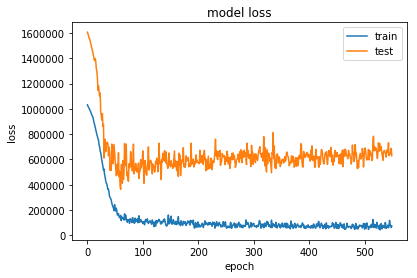

In [69]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

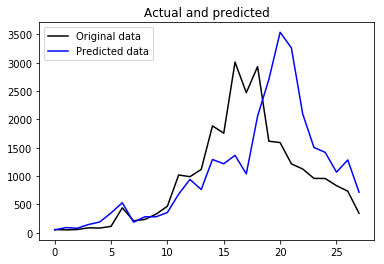

In [70]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель частично лучше повторяет структуру данных, но пики пропускает

#### модель 7, заменили relu на leaky relu, увеличили вес регуляризаций, добавили dropout

In [71]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [72]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [73]:
opt = Nadam(lr=0.001)

In [74]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [75]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/550
244/244 [==============================] - 1s 6ms/step - loss: 1034574.9641 - mean_squared_error: 1034287.6108 - val_loss: 1610220.4922 - val_mean_squared_error: 1610098.7467

Epoch 00001: val_loss improved from inf to 1610220.49219, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/550
244/244 [==============================] - 0s 270us/step - loss: 1024879.0639 - mean_squared_error: 1024505.6031 - val_loss: 1592253.2913 - val_mean_squared_error: 1592052.2556

Epoch 00002: val_loss improved from 1610220.49219 to 1592253.29129, saving model to test.hdf5
Epoch 3/550
244/244 [==============================] - 0s 213us/step - loss: 1016685.7902 - mean_squared_error: 1016165.6278 - val_loss: 1576678.9721 - val_mean_squared_error: 1576369.4900

Epoch 00003: val_loss improved from 1592253.29129 to 1576678.97210, saving model to test.hdf5
Epoch 4/550
244/244 [==============================] - 0s 218us/step - loss: 1006797.7074 - mean_squared_error: 1006120.3516 - val_loss: 1565974.0480 - val_mean_squared_error: 1565570.8292

Epoch 00004: val_loss improved from 1576678.97210 to 1565974.04799, saving model to test.hdf5
Epoch 5/550
244/244 [==============================] - 0s 287us/step - loss: 997619.1728 - mean_squared_error: 996841.3544 - val_loss: 1550221.5134 


Epoch 00062: val_loss did not improve from 542396.66462
Epoch 63/550
244/244 [==============================] - 0s 220us/step - loss: 291854.4380 - mean_squared_error: 290192.6723 - val_loss: 565892.5251 - val_mean_squared_error: 564449.6752

Epoch 00063: val_loss did not improve from 542396.66462
Epoch 64/550
244/244 [==============================] - 0s 218us/step - loss: 276326.8621 - mean_squared_error: 274705.0480 - val_loss: 509798.8862 - val_mean_squared_error: 508433.6579

Epoch 00064: val_loss improved from 542396.66462 to 509798.88616, saving model to test.hdf5
Epoch 65/550
244/244 [==============================] - 0s 232us/step - loss: 261775.4158 - mean_squared_error: 260176.6170 - val_loss: 527670.8181 - val_mean_squared_error: 526184.9096

Epoch 00065: val_loss did not improve from 509798.88616
Epoch 66/550
244/244 [==============================] - 0s 193us/step - loss: 244648.1764 - mean_squared_error: 243106.1180 - val_loss: 512660.8605 - val_mean_squared_error: 5113

244/244 [==============================] - 0s 226us/step - loss: 186551.6951 - mean_squared_error: 185057.1285 - val_loss: 456411.3945 - val_mean_squared_error: 455103.0932

Epoch 00096: val_loss did not improve from 397776.48298
Epoch 97/550
244/244 [==============================] - 0s 274us/step - loss: 215827.2579 - mean_squared_error: 214419.0824 - val_loss: 425941.8817 - val_mean_squared_error: 424599.5025

Epoch 00097: val_loss did not improve from 397776.48298
Epoch 98/550
244/244 [==============================] - 0s 256us/step - loss: 246556.1456 - mean_squared_error: 245205.1611 - val_loss: 452510.3203 - val_mean_squared_error: 451201.8415

Epoch 00098: val_loss did not improve from 397776.48298
Epoch 99/550
244/244 [==============================] - 0s 234us/step - loss: 212594.4661 - mean_squared_error: 211141.1236 - val_loss: 403229.8864 - val_mean_squared_error: 401937.5578

Epoch 00099: val_loss did not improve from 397776.48298
Epoch 100/550
244/244 [==================


Epoch 00162: val_loss did not improve from 369067.02874
Epoch 163/550
244/244 [==============================] - 0s 189us/step - loss: 169821.9402 - mean_squared_error: 168387.6871 - val_loss: 456765.4576 - val_mean_squared_error: 455496.6214

Epoch 00163: val_loss did not improve from 369067.02874
Epoch 164/550
244/244 [==============================] - 0s 264us/step - loss: 153482.4274 - mean_squared_error: 152061.0004 - val_loss: 490350.6535 - val_mean_squared_error: 489065.9054

Epoch 00164: val_loss did not improve from 369067.02874
Epoch 165/550
244/244 [==============================] - 0s 281us/step - loss: 154703.3001 - mean_squared_error: 153227.1119 - val_loss: 471466.5226 - val_mean_squared_error: 470197.9757

Epoch 00165: val_loss did not improve from 369067.02874
Epoch 166/550
244/244 [==============================] - 0s 244us/step - loss: 182650.8350 - mean_squared_error: 181309.0917 - val_loss: 443912.8298 - val_mean_squared_error: 442702.4049

Epoch 00166: val_loss d


Epoch 00229: val_loss did not improve from 369067.02874
Epoch 230/550
244/244 [==============================] - 0s 287us/step - loss: 205645.9661 - mean_squared_error: 204353.3259 - val_loss: 409863.1602 - val_mean_squared_error: 408696.4699

Epoch 00230: val_loss did not improve from 369067.02874
Epoch 231/550
244/244 [==============================] - 0s 287us/step - loss: 159981.2993 - mean_squared_error: 158706.2162 - val_loss: 458749.4141 - val_mean_squared_error: 457543.6825

Epoch 00231: val_loss did not improve from 369067.02874
Epoch 232/550
244/244 [==============================] - 0s 276us/step - loss: 184137.8829 - mean_squared_error: 182892.5407 - val_loss: 455768.2737 - val_mean_squared_error: 454540.3839

Epoch 00232: val_loss did not improve from 369067.02874
Epoch 233/550
244/244 [==============================] - 0s 254us/step - loss: 182167.7915 - mean_squared_error: 180794.3770 - val_loss: 445619.5285 - val_mean_squared_error: 444345.5865

Epoch 00233: val_loss d


Epoch 00296: val_loss did not improve from 369067.02874
Epoch 297/550
244/244 [==============================] - 0s 291us/step - loss: 139343.8796 - mean_squared_error: 137990.1552 - val_loss: 489041.9760 - val_mean_squared_error: 487793.4118

Epoch 00297: val_loss did not improve from 369067.02874
Epoch 298/550
244/244 [==============================] - 0s 240us/step - loss: 179923.0479 - mean_squared_error: 178645.6242 - val_loss: 475167.1189 - val_mean_squared_error: 473917.3418

Epoch 00298: val_loss did not improve from 369067.02874
Epoch 299/550
244/244 [==============================] - 0s 256us/step - loss: 190466.3111 - mean_squared_error: 189195.7475 - val_loss: 459377.6532 - val_mean_squared_error: 458160.8588

Epoch 00299: val_loss did not improve from 369067.02874
Epoch 300/550
244/244 [==============================] - 0s 219us/step - loss: 152403.7491 - mean_squared_error: 151055.6429 - val_loss: 475408.7511 - val_mean_squared_error: 474168.5165

Epoch 00300: val_loss d


Epoch 00363: val_loss did not improve from 369067.02874
Epoch 364/550
244/244 [==============================] - 0s 228us/step - loss: 172699.0417 - mean_squared_error: 171328.0621 - val_loss: 445368.0126 - val_mean_squared_error: 444136.2023

Epoch 00364: val_loss did not improve from 369067.02874
Epoch 365/550
244/244 [==============================] - 0s 223us/step - loss: 163177.7736 - mean_squared_error: 161856.7734 - val_loss: 467197.3304 - val_mean_squared_error: 465951.3602

Epoch 00365: val_loss did not improve from 369067.02874
Epoch 366/550
244/244 [==============================] - 0s 234us/step - loss: 155243.9174 - mean_squared_error: 153887.4869 - val_loss: 487468.9009 - val_mean_squared_error: 486189.1010

Epoch 00366: val_loss did not improve from 369067.02874
Epoch 367/550
244/244 [==============================] - 0s 218us/step - loss: 162992.6890 - mean_squared_error: 161623.1465 - val_loss: 461017.3454 - val_mean_squared_error: 459683.9049

Epoch 00367: val_loss d


Epoch 00430: val_loss did not improve from 369067.02874
Epoch 431/550
244/244 [==============================] - 0s 283us/step - loss: 127456.5606 - mean_squared_error: 126104.8710 - val_loss: 522458.7673 - val_mean_squared_error: 521137.4615

Epoch 00431: val_loss did not improve from 369067.02874
Epoch 432/550
244/244 [==============================] - 0s 285us/step - loss: 125522.0984 - mean_squared_error: 124165.4951 - val_loss: 474264.2254 - val_mean_squared_error: 472986.6007

Epoch 00432: val_loss did not improve from 369067.02874
Epoch 433/550
244/244 [==============================] - 0s 270us/step - loss: 167454.5037 - mean_squared_error: 166102.4892 - val_loss: 460925.9841 - val_mean_squared_error: 459617.9009

Epoch 00433: val_loss did not improve from 369067.02874
Epoch 434/550
244/244 [==============================] - 0s 236us/step - loss: 149317.4879 - mean_squared_error: 147942.6009 - val_loss: 468501.0265 - val_mean_squared_error: 467179.8703

Epoch 00434: val_loss d


Epoch 00497: val_loss did not improve from 369067.02874
Epoch 498/550
244/244 [==============================] - 0s 238us/step - loss: 146911.9460 - mean_squared_error: 145528.8429 - val_loss: 503034.3343 - val_mean_squared_error: 501719.5787

Epoch 00498: val_loss did not improve from 369067.02874
Epoch 499/550
244/244 [==============================] - 0s 274us/step - loss: 168025.7775 - mean_squared_error: 166620.7584 - val_loss: 522637.1038 - val_mean_squared_error: 521325.5664

Epoch 00499: val_loss did not improve from 369067.02874
Epoch 500/550
244/244 [==============================] - 0s 285us/step - loss: 136058.9423 - mean_squared_error: 134693.4069 - val_loss: 503182.5977 - val_mean_squared_error: 501898.9358

Epoch 00500: val_loss did not improve from 369067.02874
Epoch 501/550
244/244 [==============================] - 0s 285us/step - loss: 140304.8142 - mean_squared_error: 138935.4264 - val_loss: 525454.0642 - val_mean_squared_error: 524164.0592

Epoch 00501: val_loss d

#### графики

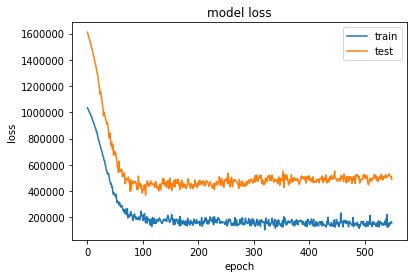

In [76]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

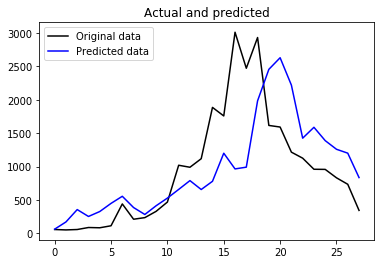

In [77]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель стала работать хуже

#### модель 8, модель переобучилась, уменьшили кол-во эпох

In [78]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [79]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [80]:
opt = Nadam(lr=0.001)

In [81]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [82]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/350
 - 2s - loss: 1034989.7170 - mean_squared_error: 1034696.7157 - val_loss: 1610189.1094 - val_mean_squared_error: 1610069.9275

Epoch 00001: val_loss improved from inf to 1610189.10938, saving model to test.hdf5
Epoch 2/350
 - 0s - loss: 1025480.7951 - mean_squared_error: 1025117.8527 - val_loss: 1593884.1540 - val_mean_squared_error: 1593694.4810

Epoch 00002: val_loss improved from 1610189.10938 to 1593884.15402, saving model to test.hdf5
Epoch 3/350
 - 0s - loss: 1015721.3532 - mean_squared_error: 1015187.2554 - val_loss: 1573430.9967 - val_mean_squared_error: 1573125.5826

Epoch 00003: val_loss improved from 1593884.15402 to 1573430.99665, saving model to test.hdf5
Epoch 4/350
 - 0s - loss: 1006579.2390 - mean_squared_error: 1005890.8456 - val_loss: 1559536.2288 - val_mean_squared_error: 1559128.0592

Epoch 00004: val_loss improved from 1573430.99665 to 1559536.22879, saving model to test.hdf5
Epoch 5/350
 - 0s - loss: 997995.

Epoch 37/350
 - 0s - loss: 537857.1237 - mean_squared_error: 536249.3489 - val_loss: 864103.6116 - val_mean_squared_error: 862580.9699

Epoch 00037: val_loss did not improve from 861385.80022
Epoch 38/350
 - 0s - loss: 522120.9791 - mean_squared_error: 520632.2134 - val_loss: 893637.2545 - val_mean_squared_error: 892117.2645

Epoch 00038: val_loss did not improve from 861385.80022
Epoch 39/350
 - 0s - loss: 507782.9265 - mean_squared_error: 506188.8421 - val_loss: 842392.1462 - val_mean_squared_error: 840785.9944

Epoch 00039: val_loss improved from 861385.80022 to 842392.14621, saving model to test.hdf5
Epoch 40/350
 - 0s - loss: 490403.7082 - mean_squared_error: 488864.9064 - val_loss: 821198.0056 - val_mean_squared_error: 819665.9275

Epoch 00040: val_loss improved from 842392.14621 to 821198.00558, saving model to test.hdf5
Epoch 41/350
 - 0s - loss: 463398.8909 - mean_squared_error: 461816.8948 - val_loss: 820349.0982 - val_mean_squared_error: 818993.3147

Epoch 00041: val_loss im


Epoch 00076: val_loss did not improve from 459628.79632
Epoch 77/350
 - 0s - loss: 209006.8827 - mean_squared_error: 207578.6735 - val_loss: 515315.5117 - val_mean_squared_error: 513924.3287

Epoch 00077: val_loss did not improve from 459628.79632
Epoch 78/350
 - 0s - loss: 224841.5038 - mean_squared_error: 223415.8511 - val_loss: 470520.9247 - val_mean_squared_error: 469146.9777

Epoch 00078: val_loss did not improve from 459628.79632
Epoch 79/350
 - 0s - loss: 199935.4011 - mean_squared_error: 198314.6636 - val_loss: 489103.7388 - val_mean_squared_error: 487717.5430

Epoch 00079: val_loss did not improve from 459628.79632
Epoch 80/350
 - 0s - loss: 218962.8042 - mean_squared_error: 217531.9491 - val_loss: 479033.3131 - val_mean_squared_error: 477706.1362

Epoch 00080: val_loss did not improve from 459628.79632
Epoch 81/350
 - 0s - loss: 201135.2176 - mean_squared_error: 199635.0049 - val_loss: 488885.4609 - val_mean_squared_error: 487450.8315

Epoch 00081: val_loss did not improve f

 - 0s - loss: 157219.3328 - mean_squared_error: 155812.9717 - val_loss: 450318.2640 - val_mean_squared_error: 449068.8192

Epoch 00119: val_loss did not improve from 416848.98968
Epoch 120/350
 - 0s - loss: 193764.2491 - mean_squared_error: 192400.6719 - val_loss: 457277.1886 - val_mean_squared_error: 455980.0742

Epoch 00120: val_loss did not improve from 416848.98968
Epoch 121/350
 - 0s - loss: 155321.9587 - mean_squared_error: 153903.1001 - val_loss: 422735.3122 - val_mean_squared_error: 421491.0653

Epoch 00121: val_loss did not improve from 416848.98968
Epoch 122/350
 - 0s - loss: 194998.7129 - mean_squared_error: 193618.2322 - val_loss: 411803.8465 - val_mean_squared_error: 410557.2006

Epoch 00122: val_loss improved from 416848.98968 to 411803.84654, saving model to test.hdf5
Epoch 123/350
 - 0s - loss: 213454.7691 - mean_squared_error: 212025.5961 - val_loss: 455968.3214 - val_mean_squared_error: 454620.6970

Epoch 00123: val_loss did not improve from 411803.84654
Epoch 124/350


Epoch 00161: val_loss did not improve from 411803.84654
Epoch 162/350
 - 0s - loss: 165944.6664 - mean_squared_error: 164551.5072 - val_loss: 506860.5982 - val_mean_squared_error: 505492.7104

Epoch 00162: val_loss did not improve from 411803.84654
Epoch 163/350
 - 0s - loss: 172610.4734 - mean_squared_error: 171159.3665 - val_loss: 506990.0765 - val_mean_squared_error: 505606.8761

Epoch 00163: val_loss did not improve from 411803.84654
Epoch 164/350
 - 0s - loss: 145798.3169 - mean_squared_error: 144346.4601 - val_loss: 467871.5898 - val_mean_squared_error: 466548.5067

Epoch 00164: val_loss did not improve from 411803.84654
Epoch 165/350
 - 0s - loss: 175548.8073 - mean_squared_error: 174023.8861 - val_loss: 444217.1032 - val_mean_squared_error: 442923.0809

Epoch 00165: val_loss did not improve from 411803.84654
Epoch 166/350
 - 0s - loss: 152145.0144 - mean_squared_error: 150597.7410 - val_loss: 442594.6071 - val_mean_squared_error: 441258.0165

Epoch 00166: val_loss did not impr

 - 0s - loss: 179562.7657 - mean_squared_error: 178132.6264 - val_loss: 467577.0435 - val_mean_squared_error: 466316.0734

Epoch 00204: val_loss did not improve from 411803.84654
Epoch 205/350
 - 0s - loss: 175638.6136 - mean_squared_error: 174280.1766 - val_loss: 451804.7210 - val_mean_squared_error: 450554.4269

Epoch 00205: val_loss did not improve from 411803.84654
Epoch 206/350
 - 0s - loss: 141559.6365 - mean_squared_error: 140058.4013 - val_loss: 447266.6283 - val_mean_squared_error: 445987.0128

Epoch 00206: val_loss did not improve from 411803.84654
Epoch 207/350
 - 0s - loss: 183874.9984 - mean_squared_error: 182526.8212 - val_loss: 449602.2188 - val_mean_squared_error: 448344.9604

Epoch 00207: val_loss did not improve from 411803.84654
Epoch 208/350
 - 0s - loss: 168109.1281 - mean_squared_error: 166582.3749 - val_loss: 471039.4118 - val_mean_squared_error: 469747.9576

Epoch 00208: val_loss did not improve from 411803.84654
Epoch 209/350
 - 0s - loss: 148841.9744 - mean_sq


Epoch 00246: val_loss did not improve from 411803.84654
Epoch 247/350
 - 0s - loss: 176500.5135 - mean_squared_error: 175149.8597 - val_loss: 472108.1925 - val_mean_squared_error: 470897.0558

Epoch 00247: val_loss did not improve from 411803.84654
Epoch 248/350
 - 0s - loss: 163451.3495 - mean_squared_error: 162088.9195 - val_loss: 464994.8337 - val_mean_squared_error: 463811.0363

Epoch 00248: val_loss did not improve from 411803.84654
Epoch 249/350
 - 0s - loss: 142140.5061 - mean_squared_error: 140800.6368 - val_loss: 428463.1512 - val_mean_squared_error: 427280.8485

Epoch 00249: val_loss did not improve from 411803.84654
Epoch 250/350
 - 0s - loss: 135721.9530 - mean_squared_error: 134347.4036 - val_loss: 443930.8376 - val_mean_squared_error: 442720.9604

Epoch 00250: val_loss did not improve from 411803.84654
Epoch 251/350
 - 0s - loss: 145575.5092 - mean_squared_error: 144190.7105 - val_loss: 489154.2985 - val_mean_squared_error: 487906.7065

Epoch 00251: val_loss did not impr

 - 0s - loss: 131658.9302 - mean_squared_error: 130342.3011 - val_loss: 485560.4219 - val_mean_squared_error: 484368.7422

Epoch 00289: val_loss did not improve from 411803.84654
Epoch 290/350
 - 0s - loss: 133569.1323 - mean_squared_error: 132257.0030 - val_loss: 502388.1814 - val_mean_squared_error: 501176.0223

Epoch 00290: val_loss did not improve from 411803.84654
Epoch 291/350
 - 0s - loss: 162123.7753 - mean_squared_error: 160729.7578 - val_loss: 494083.6864 - val_mean_squared_error: 492866.4916

Epoch 00291: val_loss did not improve from 411803.84654
Epoch 292/350
 - 0s - loss: 172098.6203 - mean_squared_error: 170820.7351 - val_loss: 481448.4381 - val_mean_squared_error: 480247.5636

Epoch 00292: val_loss did not improve from 411803.84654
Epoch 293/350
 - 0s - loss: 150833.4780 - mean_squared_error: 149451.1416 - val_loss: 456586.1496 - val_mean_squared_error: 455403.1283

Epoch 00293: val_loss did not improve from 411803.84654
Epoch 294/350
 - 0s - loss: 144294.5879 - mean_sq


Epoch 00331: val_loss did not improve from 411803.84654
Epoch 332/350
 - 0s - loss: 158397.1241 - mean_squared_error: 157054.1685 - val_loss: 467538.4403 - val_mean_squared_error: 466365.1267

Epoch 00332: val_loss did not improve from 411803.84654
Epoch 333/350
 - 0s - loss: 159630.7810 - mean_squared_error: 158329.2188 - val_loss: 493977.6814 - val_mean_squared_error: 492790.5352

Epoch 00333: val_loss did not improve from 411803.84654
Epoch 334/350
 - 0s - loss: 174208.4508 - mean_squared_error: 172959.5344 - val_loss: 495874.6189 - val_mean_squared_error: 494676.9051

Epoch 00334: val_loss did not improve from 411803.84654
Epoch 335/350
 - 0s - loss: 171048.8336 - mean_squared_error: 169796.6032 - val_loss: 505995.0424 - val_mean_squared_error: 504783.1814

Epoch 00335: val_loss did not improve from 411803.84654
Epoch 336/350
 - 0s - loss: 161897.6811 - mean_squared_error: 160677.4364 - val_loss: 491804.3800 - val_mean_squared_error: 490581.8811

Epoch 00336: val_loss did not impr

#### графики

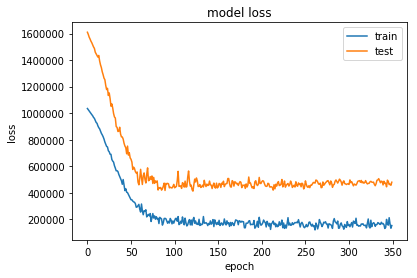

In [83]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

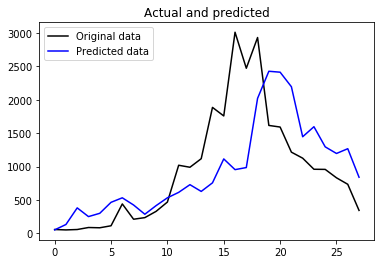

In [84]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### Вывод

1. классические функции активации (sigmoid, tanh) не работают вовсе - relu, leaky relu существенно лучше
2. добавление dropout, batchnormalization помогло увеличить общую точность, но пик продаж модель так и не схватывает
Ошибка получается существенно выше, чем при использовании классических методов анализа временных рядов

Перейдем к альтернативному способу использовани нейронной сети

## Нейронная сеть, альтернативное использование

### импорты

In [77]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from math import sqrt

Использовали несколько разных функций для проверки ошибок

In [78]:
import copy

In [79]:
df.head()

,date,sales,forecast
2012-09-09,09.09.2012,25,NaN
2012-09-16,16.09.2012,12,NaN
2012-09-23,23.09.2012,11,NaN
2012-09-30,30.09.2012,5,NaN
2012-10-07,07.10.2012,4,NaN


In [80]:
data2 = copy.deepcopy(df)

In [81]:
del data2['forecast']

### вывод таблицы

In [82]:
data2.head()

,date,sales
2012-09-09,09.09.2012,25
2012-09-16,16.09.2012,12
2012-09-23,23.09.2012,11
2012-09-30,30.09.2012,5
2012-10-07,07.10.2012,4


In [83]:
data2.columns = ['dates','sales']

### написание функций

In [13]:
def CV(X_train, Y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = Y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) 

        index = int(np.floor(X.shape[0] * split))
    
        X_trainFolds = X[:index]        
        Y_trainFolds = y[:index]

        X_testFold = X[(index + 1):]
        Y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, Y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), Y_testFold)
   
    return errors.mean()

In [85]:
def rmse(ytrue,ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred));
def mse(ytrue,ypred):
    return (mean_squared_error(ytrue, ypred));
def rmsle(ytrue, ypred):
    return mean_squared_log_error(ytrue, ypred);
def mae (ytrue,ypred):
    return mean_absolute_error(ytrue,ypred);
def r2 (ytrue,ypred):
    return r2_score(ytrue,ypred);
def evs (ytrue,ypred):
    return explained_variance_score(ytrue,ypred);
def medae (ytrue,ypred):
    return median_absolute_error(ytrue,ypred)

### подготовка данных

In [86]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(data2.sales))]
data2['index'] =date_list
data2.set_index(['index'], inplace=True)
data2.index.name=None

In [87]:
data2.dates = pd.to_datetime(data2.dates)
data2.TRDATETIME = pd.to_datetime(data2['dates'],  dayfirst= True, format='%d%b%y:%H:%M:%S')

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [88]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2012-09-09 to 2018-08-05
Data columns (total 2 columns):
dates    309 non-null datetime64[ns]
sales    309 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.2 KB


In [89]:
data2['date'] = data2['dates'].dt.date
data2['day'] = data2['dates'].dt.day
data2['month'] = data2['dates'].dt.month
data2['year'] = data2['dates'].dt.year

In [90]:
data2.head()

,dates,sales,date,day,month,year
2012-09-09,2012-09-09,25,2012-09-09,9,9,2012
2012-09-16,2012-09-16,12,2012-09-16,16,9,2012
2012-09-23,2012-09-23,11,2012-09-23,23,9,2012
2012-09-30,2012-09-30,5,2012-09-30,30,9,2012
2012-10-07,2012-07-10,4,2012-07-10,10,7,2012


In [91]:
data2['season'] = data2.sales

In [92]:
data2['season'].loc['2012':'2013-03-01'] = "aw"
data2['season'].loc['2013-03-01':'2013-09-01'] = "ss"
data2['season'].loc['2013-09-01':'2014-03-01'] = "aw"
data2['season'].loc['2014-03-01':'2014-09-01'] = "ss"
data2['season'].loc['2014-09-01':'2015-03-01'] = "aw"
data2['season'].loc['2015-03-01':'2015-09-01'] = "ss"
data2['season'].loc['2015-09-01':'2016-03-01'] = "aw"
data2['season'].loc['2016-03-01':'2016-09-01'] = "ss"
data2['season'].loc['2016-09-01':'2017-03-01'] = "aw"
data2['season'].loc['2017-03-01':'2017-09-01'] = "ss"
data2['season'].loc['2017-09-01':'2018-03-01'] = "aw"
data2['season'].loc['2018-03-01':'2018-09-01'] = "ss"

C:\Pythonn\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [93]:
data2['Last_Week_Sales'] = data2['sales'].shift()
data2['Last_Week_Diff'] = data2['Last_Week_Sales'].diff()
data2 = data2.dropna()

In [94]:
data2.head()

,dates,sales,date,day,month,year,season,Last_Week_Sales,Last_Week_Diff
2012-09-23,2012-09-23,11,2012-09-23,23,9,2012,aw,12.0,-13.0
2012-09-30,2012-09-30,5,2012-09-30,30,9,2012,aw,11.0,-1.0
2012-10-07,2012-07-10,4,2012-07-10,10,7,2012,aw,5.0,-6.0
2012-10-14,2012-10-14,6,2012-10-14,14,10,2012,aw,4.0,-1.0
2012-10-21,2012-10-21,2,2012-10-21,21,10,2012,aw,6.0,2.0


In [95]:
data2['weeks'] = list(range(len(data2.index)))

In [96]:
data2.index = list(range(len(data2.index)))

In [97]:
data2.drop('dates', axis = 1, inplace = True)

In [98]:
data2.drop('date', axis = 1, inplace = True)

In [99]:
data2.head()

,sales,day,month,year,season,Last_Week_Sales,Last_Week_Diff,weeks
0,11,23,9,2012,aw,12.0,-13.0,0
1,5,30,9,2012,aw,11.0,-1.0,1
2,4,10,7,2012,aw,5.0,-6.0,2
3,6,14,10,2012,aw,4.0,-1.0,3
4,2,21,10,2012,aw,6.0,2.0,4


In [100]:
data3 = pd.get_dummies(data2)

In [101]:
data3.head()

,sales,day,month,year,Last_Week_Sales,Last_Week_Diff,weeks,season_aw,season_ss
0,11,23,9,2012,12.0,-13.0,0,1,0
1,5,30,9,2012,11.0,-1.0,1,1,0
2,4,10,7,2012,5.0,-6.0,2,1,0
3,6,14,10,2012,4.0,-1.0,3,1,0
4,2,21,10,2012,6.0,2.0,4,1,0


In [102]:
Y = data3.sales

In [103]:
X = data3.drop('sales', axis = 1)

In [104]:
X_train = data3[:296].drop('sales', axis = 1)
Y_train = data3[:296].sales

In [105]:
X_test = data3[296:].drop('sales', axis = 1)
Y_test = data3[296:].sales

### Итоговая модель из 3.2

In [106]:
model = Sequential()
model.add(Dense(64, input_dim=8,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [107]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [108]:
opt = Nadam(lr=0.01)

In [109]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

### Прогон модели через функцию performCV

In [110]:
CV(X_train, Y_train, 100, model, rmse)

Size train set: (296, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)
Epoch 1/1
2/2 [==============================] - 1s 483ms/step - loss: 682419.6250 - mean_squared_error: 82.5359

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)
Epoch 1/1
4/4 [==============================] - 0s 493us/step - loss: 1220300.6250 - mean_squared_error: 30.9488

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)
Epoch 1/1
6/6 [==============================] - 0s 669us/step - loss: 1649818.3750 - mean_squared_error: 22.6080

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)
Epoch 1/1
8/8 [==============================] - 0s 249us/step - loss: 1978272.0000 - mean_squared_error: 26.7460

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 2209914.7500 - mean_squared_error: 6.0778

Splitting the first 7 chunks at 6/7
Size of train +

Epoch 1/1
174/174 [==============================] - 0s 123us/step - loss: 113024.5866 - mean_squared_error: 81029.6137

Splitting the first 89 chunks at 88/89
Size of train + test: (178, 8)
Epoch 1/1
176/176 [==============================] - 0s 122us/step - loss: 86881.5696 - mean_squared_error: 64516.7791

Splitting the first 90 chunks at 89/90
Size of train + test: (180, 8)
Epoch 1/1
178/178 [==============================] - 0s 112us/step - loss: 97337.3662 - mean_squared_error: 77692.3067

Splitting the first 91 chunks at 90/91
Size of train + test: (182, 8)
Epoch 1/1
180/180 [==============================] - 0s 114us/step - loss: 79294.9712 - mean_squared_error: 63581.4354

Splitting the first 92 chunks at 91/92
Size of train + test: (184, 8)
Epoch 1/1
182/182 [==============================] - 0s 121us/step - loss: 93995.9940 - mean_squared_error: 80734.9326

Splitting the first 93 chunks at 92/93
Size of train + test: (186, 8)
Epoch 1/1
184/184 [==============================

279.3182088702616

### Валидационное предсказание

In [112]:
rmse(Y_test, model.predict(X_test))

414.0811935906845

### Вывод

Подход с кроссвалидацией нейронных сетей помог существенно снизить ошибку, но не перебить методы классического анализа временных рядов

## Классические методы ML

В классических методах ML будем использовать аналогичный 3.3 способ

### импорты

In [120]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [121]:
from xgboost import XGBRegressor

### RFR

In [122]:
mdl = RandomForestRegressor(n_estimators=1000, criterion='mse',n_jobs=-1)

In [123]:
CV(X_train, Y_train, 100, mdl, rmse)

Size train set: (296, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (14, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (16, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (18, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (20, 8)

Splitting the first 11 chunks at 10/11
Size of train + test: (22, 8)

Splitting the first 12 chunks at 11/12
Size of train + test: (24, 8)

Splitting the first 13 chunks at 12/13
Size of train + test: (26, 8)

Splitting the first 14 chunks at 13/14
Size of train + test: (28, 8)

Splitting the first 15 chunks at 14/15
Size of train + test: (30, 8)

S

179.50273737373735

#### Предсказание

In [124]:
rfrpred = mdl.predict(X_test)

In [125]:
rmse(Y_test, rfrpred )

360.451564164124

### XGBR

In [126]:
mdl1 = XGBRegressor(learning_rate=0.01, n_estimators=10000, booster='gblinear' )

In [127]:
CV(X_train, Y_train, 110, mdl1, rmse)

Size train set: (296, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (14, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (16, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (18, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (20, 8)

Splitting the first 11 chunks at 10/11
Size of train + test: (22, 8)

Splitting the first 12 chunks at 11/12
Size of train + test: (24, 8)

Splitting the first 13 chunks at 12/13
Size of train + test: (26, 8)

Splitting the first 14 chunks at 13/14
Size of train + test: (28, 8)

Splitting the first 15 chunks at 14/15
Size of train + test: (30, 8)

S

151.8792785356898

#### Предсказание

In [128]:
XGBRpred = mdl1.predict(X_test)

In [129]:
rmse(Y_test, XGBRpred )

406.40865580558193

### LinReg

In [130]:
import sklearn.linear_model as lm

In [131]:
mdl2 = lm.LinearRegression(normalize=False)

In [132]:
CV(X_train, Y_train, 130, mdl2, rmse)

Size train set: (296, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (14, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (16, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (18, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (20, 8)

Splitting the first 11 chunks at 10/11
Size of train + test: (22, 8)

Splitting the first 12 chunks at 11/12
Size of train + test: (24, 8)

Splitting the first 13 chunks at 12/13
Size of train + test: (26, 8)

Splitting the first 14 chunks at 13/14
Size of train + test: (28, 8)

Splitting the first 15 chunks at 14/15
Size of train + test: (30, 8)

S

163.5005000939232

#### Предсказание

In [133]:
lrpred = mdl2.predict(X_test)

In [134]:
rmse(Y_test, lrpred )

410.80191453524554

## Выводы по моделям

1.  в целом, на кросс-валидации все модели (включая keras из другого файла) показали себя существенно лучше.
2. лучше всего на кроссвалидации выступила обычная линейная регрессия
3. модели еще не проходили полноценный "тюнинг", проверил несколько параметров по наитию
4. пока еще не сделаны финальные предсказания, но результат, в целом, неплохой
5. продублирую вопрос из файла с keras - есть проблема с выбором метрики ошибки, тут нужна помощь

# Результаты

## Оценка и валидация модели: привести значения метрик
качества для итоговой модели, подтвердить робастность
модели (надежности и устойчивости к шумам, выбросам и
ошибочным данным). Если есть общедоступные, похожие
решения, сравнить свою модель с ними.

SARIMAX RMSE = 534.29
KERAS classic RMSE = >>1000
KERAS alt RMSE = 775
RFR RMSE = 360.45
XGBR RMSE = 406.41
LR RMSE = 410.81

Как видно из расчетов, в условиях недостаточности данных (309 значений), нейронные сети в нескольких вариантах существенно хуже справляются с задачей, чем ski-kit learn и классические методы анализа временных рядов

## Внедрение, подтверждение результата (если применимо):

Обосновать работоспособность и необходимость введения такой практики продаж еще предстоит

# Выводы и заключение

## Перечисление выводов: решена ли исходная задача,

1. Задача решена достаточно хорошо, в целом, все методы, кроме классического применения нейронных сетей, показали себя хорошо. Основной сложностью было отсутствие у разных алгоритмов единой метрики оценки.
2. В целом, на ярко выраженных сезонных данных решение задачи не составило большого труда. опробовать модель на несезонных товарах еще предстоит.
насколько хорошо, краткое перечислить основные
сложности решения задачи, найденные закономерности и
другие интересные факты. Желательно визуализировать
основные результаты решения и качество итоговой модели.


## Дальнейшее развитие: 

В дальнейшем, кроме опробации решения на несезонных товарах планируется решить задачу динамического ценообразования (аналог билетов на самолеты)

# Список источников.

1. www.habr.ru
2. www.stackoverflow.com
3. методические материалы с курса
4. www.medium.com
5. Прикладное машинное обучение с skikit-learn и Tensorflow. изд. O`Riely, 2018


# Свернутый файл, черновики, читать не нужно

In [135]:
Главное
В дипломном проекте вы примените знания и навыки, которые
приобрели в ходе программы, чтобы решить реальную задачу.
Когда будете искать решение, пройдёте ключевые стадии создания
data science-проекта. Вам предстоит сформулировать проблему,
изучить данные, построить модель, визуализировать результаты и
предложить улучшения.
Что такое диплом
Дипломный проект состоит в том, чтобы создать и по возможности
внедрить machine learning-решение для реальной, а не учебной
задачи.
В ходе работы над дипломом вы получите опыт:
− выделения проблем и формулирования задачи в терминах data
science;
− первичного исследования данных, работы с их признаками (feature
engineering);
− выбора ML-моделей и метрик качества;
− построения и обучения ML-моделей;
− анализа и визуализации результатов моделей;
− документирования и написания отчёта о проделанной работе.
Цели дипломного проекта
− применить полученные в ходе программы знания и навыки, чтобы
решить реальную задачу;
− пройти все стадии создания проекта: от формулировки задачи
до презентации результатов;
− добавить выполненный проект data science в резюме.
Кроме того, проект нужен, чтобы получить диплом гособразца о
профессиональной переподготовке. Остальные — те, кто не
защитятся — получат сертификат о том, что прошли программу.


SyntaxError: invalid syntax (<ipython-input-135-87b353dbf0ca>, line 2)

aa

Этапы выполнения дипломного
проекта
1. Сформулировать проблему и задачу, обосновать важность,
выбрать ключевые метрики качества.
Что появится в отчёте
Раздел 1: общий обзор, проблема, обоснование важности и
стратегия решения, целевые метрики.
2. Собрать и изучить данные: оценить их качество,
распределение, выделить аномалии и зависимости; найти
аналогичные решения и публикации; составить гипотезы о
значимости различных признаков.
Что появится в отчёте
Частично раздел 2: обзор аналогичных решений,
предварительный анализ.
3. Подобрать алгоритмы, техники и библиотеки, чтобы решить
исходную задачу
Что появится в отчёте
Раздел 2: алгоритмы и техники.
4. Подготовить данные: очистить, преобразовать, выбрать способ
представления и хранения, разделить на train и test.
Что появится в отчёте
Частично раздел 3: предобработка данных.
5. Подобрать и обучить модель: реализовать алгоритм и/или
ансамбль, подобрать параметры, по необходимости изменить
набор признаков исходных данных (feature engineering),
итеративно повышать качество модели.
Что появится в отчёте
Раздел 3: предобработка данных (дополнения и изменения),
реализация, итоговая модель; часть раздела 4: оценка и
валидация модели.

6. Обобщить результаты, визуализировать их, сделать выводы,
подготовить драфт отчёта об исследовании.
Что появится в отчёте
Разделы 4 и 5: внедрение (если применимо), перечисление
выводов, дальнейшее развитие.
7. Подготовить материалы для защиты: iPython-ноутбук(и), отчёт об
исследовании, readme-файл, презентацию.
Что появится в отчёте
Вычитанный и понятный текст отчёта, ссылки на ноутбуки и
источники, форматирование текста.

Работа с ментором
Общий порядок
Когда готовите проект, вам будет помогать ментор. Ментор —
опытный специалист в предметной области или решении класса
задач, к которому относится ваш проект. Задача его (её) — дать
обратную связь по работе и, если нужно, скорректировать
направление, в котором ищете решение.
Формат работы — онлайн-консультации голосом.
Продолжительность — 30 минут. Рекомендуем устраивать
консультации не чаще одного раза в 1-2 недели.
Чтобы не тратить впустую ни менторское, ни ваше время, к каждой
встрече вам нужно будет проделать часть работы по проекту и
ответить на несколько вопросов, описав, что сделали. Ответы нужно
будет перед встречей отправить ментору
Вы можете задавать ментору вопросы онлайн, встречаться лично и
взаимодействовать сверх стандартных консультаций, если
договоритесь об этом. Частота ограничена только свободным
временем менторов.
Примерное содержание консультаций
1. Установочная: знакомство
− рассказ о себе: чем занимаетесь сейчас, как хотите
развиваться, почему выбрали этот проект (мотивация), какой
опыт в выбранной области;
− формулировка проблемы и задачи дипломной работы;
− обоснование важности проблемы;
− ключевые метрики качества.
2. Состав и сбор данных
− какие данные и откуда их брать, доступный объём;
− априорные знания о данных: структура, зависимости,
аномалии;

− результаты первичного анализа данных.
3. Структура данных, разделение train-test, алгоритмы и техники
− результаты более подробного анализа данных;
− разделение данных по выборкам, учет их структуры и
характера зависимостей;
− подбор методов решения задачи: алгоритмы, техники,
библиотеки.
4. Обучение модели. Несколько встреч, которые повторяются по
необходимости;
− обсуждение результатов;
− предложение способов улучшения.
5. Обобщение результатов и подготовка драфта отчёта об
исследовании. Не позже, чем за 1 неделю до защиты.
6. Презентация результатов — предзащита — за неделю до защиты.
− сдача материалов ментору;
− обсуждение итоговых результатов;
− прогон защиты дипломной работы перед ментором.

Оценка дипломной работы
Оценивают диплом по заранее описанным критериям отдельно
ментор и члены дипломной комиссии.
Проект оценивается по каждому критерию по 5-балльной шкале,
где 1 — полностью не соответствует критерию, а 5 — полностью
соответствует.
Критерии объединены в разделы, соответствующие разделам отчёта
об исследовании. Оценка раздела — средний балл по всем
критериям этого раздела. Оценка диплома — средневзвешенная
оценка разделов. Итоговая оценка диплома — среднее
арифметическое оценок ментора и дипломной комиссии.
Критерии, веса разделов и правила расчета оценок приведены в
файле.

Рекомендуемые сроки выполнения
(придерживаться не обязательно)

12 августа — формулирование задачи с ментором
19 августа — получение данных, построение гипотез
26 августа — анализ данных, подготовка
2 сентября — построение моделей, их сравнение
7 сентября — улучшение модели
13 сентября — подготовка отчета об исследовании, презентации

Ключевые даты
(вот это обязательно)
12 августа — формулировка задачи с ментором
8 сентября — предзащита у ментора
13 сентября — сдача материалов
15 сентября — защита проектов